## GoodReads Young Adult Book Reviews

### Install Packages & Import Libraries

In [ ]:
!pip install langdetect
# !python -m spacy download en_core_web_sm
# !pip install -U sentence-transformers
# !pip install pandas pyarrow
# !pip install langdetect
# !pip install fastparquet
!pip install simhash
!pip install -U bertopic
!pip install streamlit pyngrok -q
!pip install bertopic

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 53.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993223 sha256=4a4d0e0eca01d7342a9a8ad36d0889df5da378bbe9f1df537fac06f1763aaed0
  Stored in directory: /root/.cache/pip/wheels/0a/f2/b2/e5ca405801e05eb7c8ed5b3b4bcf1fcabcd6272c167640072e
Successfully built langdetect
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.0/153.0 kB 16.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 130.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 101.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 56.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━

In [ ]:
import pandas as pd
import numpy as np
import re
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from sklearn.feature_extraction.text import TfidfVectorizer
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from simhash import Simhash, SimhashIndex
from bertopic import BERTopic
from collections import defaultdict
from tqdm import tqdm
from pyngrok import ngrok
from umap import UMAP
from hdbscan import HDBSCAN
from langdetect import detect
from sklearn.feature_extraction.text import CountVectorizer
from textblob import TextBlob
import matplotlib.pyplot as plt

# spaCy's English model
nlp = spacy.load("en_core_web_sm")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Prepare Data

#### Load data

In [ ]:
# books and reviews metadata
books = pd.read_json("/content/drive/MyDrive/APAN 5430 NLP Group Project/Goodreads/data/goodreads_books_young_adult.json", orient="records", lines=True)
reviews = pd.read_json("/content/drive/MyDrive/APAN 5430 NLP Group Project/Goodreads/data/goodreads_reviews_young_adult.json", orient="records", lines=True)

In [ ]:
print(books.columns)

Index(['isbn', 'text_reviews_count', 'series', 'country_code', 'language_code',
       'popular_shelves', 'asin', 'is_ebook', 'average_rating', 'kindle_asin',
       'similar_books', 'description', 'format', 'link', 'authors',
       'publisher', 'num_pages', 'publication_day', 'isbn13',
       'publication_month', 'edition_information', 'publication_year', 'url',
       'image_url', 'book_id', 'ratings_count', 'work_id', 'title',
       'title_without_series'],
      dtype='object')


In [ ]:
print(reviews.columns)

Index(['user_id', 'book_id', 'review_id', 'rating', 'review_text',
       'date_added', 'date_updated', 'read_at', 'started_at', 'n_votes',
       'n_comments'],
      dtype='object')


#### Pulling Relevant Columns

In [ ]:
books_columns = [
    'book_id',
    'title',
    'title_without_series',
    'authors',
    'publisher',
    'average_rating',
    'ratings_count',
    'text_reviews_count',
    'description',
    'popular_shelves',
    'similar_books',
    'language_code',
    'format'
]

In [ ]:
reviews_columns = [
    'book_id',
    'review_text',
    'rating',
    'date_added',
    'read_at',
    'started_at',
    'user_id',
    'n_votes',
    'n_comments'
]

In [ ]:
books = books[books_columns]
reviews = reviews[reviews_columns]

#### Checking dataframe

In [ ]:
len(books)

93398

In [ ]:
len(reviews)

2389900

In [ ]:
len(books['book_id'].unique())

93398

In [ ]:
len(reviews['book_id'].unique())

93267

In [ ]:
books['book_id'].isin(reviews['book_id']).all()

np.False_

In [ ]:
reviews['book_id'].isin(books['book_id']).all()

np.True_

#### Cutting data (file too large, too many reivews)

Keep only English Reviews

In [ ]:
def is_english_langdetect(text):
    try:
        if pd.isna(text) or text == '':
            return False
        return detect(text) == 'en'
    except:
        return False  # Return False for texts that can't be detected

# Filter for English reviews
reviews = reviews[reviews['review_text'].apply(is_english_langdetect)]

Only keeping top 500 books with at least 5 or more reviews and less than 10 reviews

In [ ]:
# Drop null and unrated reviews
reviews = reviews.dropna(subset=['review_text'])
reviews = reviews[reviews['rating'] > 0]

In [ ]:
len(reviews)

2069893

In [ ]:
# Count reviews per book
review_counts = reviews.groupby('book_id').size().reset_index(name='review_count')

In [ ]:
# Select top 500 books with at least 5 reviews
top_books = (
    review_counts[review_counts['review_count'] >= 5]
    .sort_values('review_count', ascending=False)
    .head(500)
)
top_book_ids = top_books['book_id'].tolist()

In [ ]:
# Filter reviews and books
filtered_reviews = reviews[reviews['book_id'].isin(top_book_ids)]
filtered_books = books[books['book_id'].isin(top_book_ids)]

In [ ]:
# Cap reviews per book to 10
filtered_reviews = (
    filtered_reviews
    .groupby('book_id')
    .apply(lambda x: x.sample(n=min(len(x), 10), random_state=42))
    .reset_index(drop=True)
)

/tmp/ipython-input-3163570066.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(n=min(len(x), 10), random_state=42))


In [ ]:
print(f"Filtered books: {len(filtered_books):,}")
print(f"Filtered reviews: {len(filtered_reviews):,}")

Filtered books: 500
Filtered reviews: 5,000


#### Merge Books and Reviews

In [ ]:
# Merge into books
df = filtered_reviews.merge(filtered_books, on='book_id', how='inner')

#### Save filtered df to parquet

In [ ]:
df.to_parquet("/content/drive/MyDrive/APAN 5430 NLP Group Project/Goodreads/data/goodreads_young_adult_filtered.parquet", index=False)

### Preprocess Reviews

In [ ]:
def preprocess_text(text):
    # Basic cleaning
    text = re.sub(r"<.*?>", " ", text)                # Remove HTML
    text = re.sub(r"http\S+|www\S+", " ", text)       # Remove URLs
    text = re.sub(r"[^a-zA-Z\s]", " ", text)          # Remove punctuation/numbers
    text = re.sub(r"\s+", " ", text).strip().lower()  # Normalize whitespace and lowercase

    # Process with spaCy
    doc = nlp(text)

    tokens = [
        token.lemma_ for token in doc
        if token.is_alpha
        and not token.is_stop
        and len(token.lemma_) > 1
    ]

    return " ".join(tokens)

# Apply to each review
df['clean_review'] = df['review_text'].dropna().apply(preprocess_text)


#### Save preprocessed df to parquet

In [ ]:
df.to_parquet("/content/drive/MyDrive/APAN 5430 NLP Group Project/Goodreads/data/goodreads_young_adult_preprocessed.parquet", index=False)

In [ ]:
df = pd.read_parquet("/content/drive/MyDrive/APAN 5430 NLP Group Project/Goodreads/data/goodreads_young_adult_preprocessed.parquet")
#df = pd.read_parquet("/content/drive/MyDrive/goodreads_young_adult_preprocessed.parquet")

In [ ]:
len(df)

5000

In [ ]:
df = df[df['clean_review'].astype(str).str.len() > 0].reset_index(drop=True)

In [ ]:
print(df.head())

   book_id                                        review_text  rating  \
0       50  Could not put this book down!!!! Brian is a sm...       5   
1       50  I read this book probably a dozen times growin...       5   
2       50  read in high school. really enjoyed it. reread...       4   
3       50  Now I get it! Now I understand why this book i...       4   
4       50  It's too bad I didn't read this as a kid--judg...       3   

                       date_added                         read_at  \
0  Thu Jun 27 05:34:54 -0700 2013  Thu Jun 27 11:45:01 -0700 2013   
1  Thu Mar 02 07:07:04 -0800 2017  Fri Mar 03 15:52:36 -0800 2017   
2  Wed Nov 23 13:17:51 -0800 2016  Tue Nov 08 00:00:00 -0800 2016   
3  Sun Sep 09 13:35:52 -0700 2007  Sat Mar 29 00:00:00 -0700 2008   
4  Fri Dec 27 09:58:43 -0800 2013  Fri Dec 27 10:00:52 -0800 2013   

                       started_at                           user_id  n_votes  \
0  Thu Jun 27 00:00:00 -0700 2013  e97706a5d6e36cf21262a02eb3389b7

In [ ]:
print(df.columns.to_list())

['book_id', 'review_text', 'rating', 'date_added', 'read_at', 'started_at', 'user_id', 'n_votes', 'n_comments', 'title', 'title_without_series', 'authors', 'publisher', 'average_rating', 'ratings_count', 'text_reviews_count', 'description', 'popular_shelves', 'similar_books', 'language_code', 'format', 'clean_review']


In [ ]:
len(df)

4996

In [ ]:
# Structure
print(f"Dataset shape: {df.shape}")
print(f"Columns: {list(df.columns)}")
print(f"Number of reviews: {len(df)}")
print(f"Unique books: {df['book_id'].nunique()}")
print(f"Average reviews per book: {len(df) / df['book_id'].nunique():.1f}")
print()

Dataset shape: (4996, 22)
Columns: ['book_id', 'review_text', 'rating', 'date_added', 'read_at', 'started_at', 'user_id', 'n_votes', 'n_comments', 'title', 'title_without_series', 'authors', 'publisher', 'average_rating', 'ratings_count', 'text_reviews_count', 'description', 'popular_shelves', 'similar_books', 'language_code', 'format', 'clean_review']
Number of reviews: 4996
Unique books: 500
Average reviews per book: 10.0



In [ ]:
# Check for missing values in clean_review
missing_reviews = df['clean_review'].isnull().sum()
empty_reviews = (df['clean_review'].astype(str).str.strip() == '').sum()

print(f"Missing reviews: {missing_reviews}")
print(f"Empty reviews: {empty_reviews}")
print()

Missing reviews: 0
Empty reviews: 0



In [ ]:
# Show sample reviews
print("Sample reviews: ")
for i in range(3):
    if i < len(df):
        print(f"  {i+1}. {str(df['clean_review'].iloc[i])[:100]}...")
print()

Sample reviews: 
  1. book brian smart kid lot smart plane crash canadian wilderness amazing writing adventure suspense...
  2. read book probably dozen time grow probably read dozen adult timeless book feel relevant entertain m...
  3. read high school enjoy reread audio pretty good...



### Simhash Deduplication

Used hamming_distance = 10

In [ ]:
# Make a copy to preserve original count
df_original = df.copy()
original_count = len(df_original)

df['id'] = df.index.astype(str)

# Ensure text column is string
df['clean_review'] = df['clean_review'].astype(str)

# Construct SimHash Objects
f = 64  # number of bits in SimHash
objs = []
for i, row in df.iterrows():
    tokens = str(row['clean_review']).split()  # tokenizing the review
    sh = Simhash(tokens, f=f)
    objs.append((str(row['id']), sh))

# Create Simhash index for near-duplicate search
# TRIED: 6, 8, 10, 12, 15
hamming_distance = 10  # smaller = stricter deduplication
index = SimhashIndex(objs, k=hamming_distance, f=f)

# Create dictionary from (id, Simhash) pairs
simhash_map = dict(objs)

# Deduplicate reviews
seen_ids = set()
keep_ids = []  # Keep IDs of unique reviews
deduplicated_simhash = []

for i, row in df.iterrows():
    current_id = str(row['id'])
    if current_id in seen_ids:
        continue

    # Skip if this ID doesn't have a SimHash (e.g., empty review)
    if current_id not in simhash_map:
        continue

    duplicates = index.get_near_dups(simhash_map[current_id])
    seen_ids.update(duplicates)
    deduplicated_simhash.append(row.to_dict())
    keep_ids.append(current_id)

# Keep only unique reviews
df = df[df['id'].isin(keep_ids)].reset_index(drop=True)

Streaming output truncated to the last 5000 lines.


### Evaluation

Of the 4996 reviews, 219 reviews (4.38%) were identified as near-identical reviews and removed.

In [ ]:
# Calculate and display deduplication statistics
dedup_count = len(deduplicated_simhash)
duplicates_removed = original_count - dedup_count
percent_removed = (duplicates_removed / original_count) * 100

print(f"Original reviews: {original_count}")
print(f"After SimHash deduplication: {dedup_count}")
print(f"Duplicates removed: {duplicates_removed} ({percent_removed:.2f}%)")

Original reviews: 4996
After SimHash deduplication: 4777
Duplicates removed: 219 (4.38%)


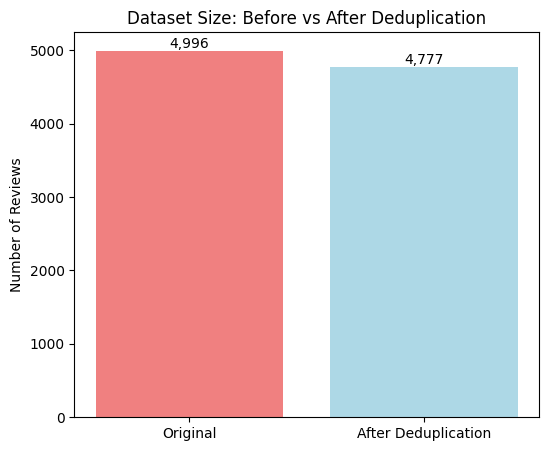

In [ ]:
labels = ['Original', 'After Deduplication']
counts = [ original_count, dedup_count]
colors = ['lightcoral', 'lightblue']

plt.figure(figsize=(6, 5))
bars = plt.bar(labels, counts, color=colors)
plt.title('Dataset Size: Before vs After Deduplication')
plt.ylabel('Number of Reviews')

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height):,}', ha='center', va='bottom')

plt.show()


#### Save simhashed df to parquet

In [ ]:
df.to_parquet("/content/drive/MyDrive/APAN 5430 NLP Group Project/Goodreads/data/goodreads_simhash.parquet", index=False)

### Topic Modeling

In [ ]:
df = pd.read_parquet("/content/drive/MyDrive/APAN 5430 NLP Group Project/Goodreads/data/goodreads_simhash.parquet")

In [ ]:
mask = df['clean_review'].str.strip().str.len() > 20
texts_filtered = df.loc[mask, 'clean_review'].tolist()

print(f"Original reviews: {len(df)}")
print(f"Filtered reviews (>20 chars): {len(texts_filtered)}")
print(f"Filtering removed: {len(df) - len(texts_filtered)} short reviews")

Original reviews: 4777
Filtered reviews (>20 chars): 4559
Filtering removed: 218 short reviews


#### SBERT Embeddings

In [ ]:
#SBERT Embeddings
sbert_model = SentenceTransformer("all-MiniLM-L6-v2")

# Encode filtered texts to embeddings
sample_embeddings = sbert_model.encode(
    texts_filtered,
    show_progress_bar=True,
    convert_to_numpy=True
)

print(f"Embeddings shape: {sample_embeddings.shape}")

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/143 [00:00<?, ?it/s]

Embeddings shape: (4559, 384)


#### BERTopic Default

In [ ]:
# Initialize BERTopic
topic_model = BERTopic(verbose=True)

# Fit and transform filtered texts with embeddings
topics, probs = topic_model.fit_transform(texts_filtered, sample_embeddings)

2025-08-14 23:51:18,628 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-08-14 23:51:42,373 - BERTopic - Dimensionality - Completed ✓
2025-08-14 23:51:42,374 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-08-14 23:51:42,590 - BERTopic - Cluster - Completed ✓
2025-08-14 23:51:42,594 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-08-14 23:51:42,844 - BERTopic - Representation - Completed ✓


In [ ]:
# Get topic information
topic_info = topic_model.get_topic_info()
n_topics = len(topic_info) - 1  # Exclude noise topic (-1)
noise_count = sum(1 for t in topics if t == -1)
coverage = ((len(topics) - noise_count) / len(topics)) * 100

print(f"\nDefault BERTopic Results:")
print("=" * 40)
print(f"Total topics discovered: {n_topics}")
print(f"Noise documents (topic -1): {noise_count:,}")
print(f"Successfully clustered: {len(topics) - noise_count:,}")
print(f"Coverage: {coverage:.1f}%")
print(f"Noise rate: {(noise_count/len(topics)*100):.1f}%")


Default BERTopic Results:
Total topics discovered: 50
Noise documents (topic -1): 2,259
Successfully clustered: 2,300
Coverage: 50.4%
Noise rate: 49.6%


In [ ]:
print(f"\n📈 Topic Distribution (Default):")
print("-" * 40)

# Show all topics with their sizes
topic_dist = pd.Series(topics).value_counts().sort_index()

print("Topic sizes:")
for topic_id, count in topic_dist.items():
    pct = (count / len(topics)) * 100
    if topic_id == -1:
        print(f"  Noise:     {count:4,} docs ({pct:5.1f}%)")
    else:
        topic_name = topic_info[topic_info['Topic'] == topic_id]['Name'].values[0]
        # Truncate long names for display
        display_name = topic_name[:50] + "..." if len(topic_name) > 50 else topic_name
        print(f"  Topic {topic_id:2d}: {count:4,} docs ({pct:5.1f}%) - {display_name}")


📈 Topic Distribution (Default):
----------------------------------------
Topic sizes:
  Noise:     2,259 docs ( 49.6%)
  Topic  0:  466 docs ( 10.2%) - 0_book_like_character_love
  Topic  1:  231 docs (  5.1%) - 1_teen_school_read_kid
  Topic  2:  141 docs (  3.1%) - 2_ending_end_series_cliffhanger
  Topic  3:  137 docs (  3.0%) - 3_love_book_like_know
  Topic  4:  105 docs (  2.3%) - 4_vampire_twilight_academy_bella
  Topic  5:   81 docs (  1.8%) - 5_cry_emotion_laugh_heart
  Topic  6:   79 docs (  1.7%) - 6_wasn_book_like_didn
  Topic  7:   71 docs (  1.6%) - 7_love_romance_adorable_story
  Topic  8:   59 docs (  1.3%) - 8_series_wait_highly_book
  Topic  9:   54 docs (  1.2%) - 9_percy_jackson_riordan_rick
  Topic 10:   50 docs (  1.1%) - 10_book_read_find_well
  Topic 11:   45 docs (  1.0%) - 11_fairy_tale_beast_cinderella
  Topic 12:   44 docs (  1.0%) - 12_wait_good_book_read
  Topic 13:   41 docs (  0.9%) - 13_star_rating_actual_agh
  Topic 14:   40 docs (  0.9%) - 14_spoiler_a

#### BERTopic with a lower min_topic_size for more topics

In [ ]:
# Initialize BERTopic with a lower min_topic_size for more topics
topic_model = BERTopic(min_topic_size = 5,
                       nr_topics = None,
                       verbose = True)

# Fit and transform filtered texts with embeddings
topics, probs = topic_model.fit_transform(texts_filtered, sample_embeddings)

2025-08-14 23:51:54,458 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-08-14 23:51:56,583 - BERTopic - Dimensionality - Completed ✓
2025-08-14 23:51:56,584 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-08-14 23:51:56,812 - BERTopic - Cluster - Completed ✓
2025-08-14 23:51:56,816 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-08-14 23:51:57,131 - BERTopic - Representation - Completed ✓


In [ ]:
# Get topic information
topic_info = topic_model.get_topic_info()
n_topics = len(topic_info) - 1  # Exclude noise topic (-1)
noise_count = sum(1 for t in topics if t == -1)
coverage = ((len(topics) - noise_count) / len(topics)) * 100

print(f"\nLower min_topic_size BERTopic Results:")
print("=" * 40)
print(f"Total topics discovered: {n_topics}")
print(f"Noise documents (topic -1): {noise_count:,}")
print(f"Successfully clustered: {len(topics) - noise_count:,}")
print(f"Coverage: {coverage:.1f}%")
print(f"Noise rate: {(noise_count/len(topics)*100):.1f}%")


Lower min_topic_size BERTopic Results:
Total topics discovered: 127
Noise documents (topic -1): 2,275
Successfully clustered: 2,284
Coverage: 50.1%
Noise rate: 49.9%


In [ ]:
print(f"\n📈 Topic Distribution (lower min_topic_size):")
print("-" * 40)

# Show all topics with their sizes
topic_dist = pd.Series(topics).value_counts().sort_index()

print("Topic sizes:")
for topic_id, count in topic_dist.items():
    pct = (count / len(topics)) * 100
    if topic_id == -1:
        print(f"  Noise:     {count:4,} docs ({pct:5.1f}%)")
    else:
        topic_name = topic_info[topic_info['Topic'] == topic_id]['Name'].values[0]
        # Truncate long names for display
        display_name = topic_name[:50] + "..." if len(topic_name) > 50 else topic_name
        print(f"  Topic {topic_id:2d}: {count:4,} docs ({pct:5.1f}%) - {display_name}")


📈 Topic Distribution (lower min_topic_size):
----------------------------------------
Topic sizes:
  Noise:     2,275 docs ( 49.9%)
  Topic  0:  230 docs (  5.0%) - 0_teen_kid_school_young
  Topic  1:  107 docs (  2.3%) - 1_like_know_book_feel
  Topic  2:   62 docs (  1.4%) - 2_spoiler_alert_end_like
  Topic  3:   61 docs (  1.3%) - 3_wasn_didn_expect_like
  Topic  4:   57 docs (  1.3%) - 4_peculiar_series_dark_trilogy
  Topic  5:   54 docs (  1.2%) - 5_series_wait_highly_pack
  Topic  6:   54 docs (  1.2%) - 6_cry_laugh_emotion_beautiful
  Topic  7:   48 docs (  1.1%) - 7_love_kaz_romance_margo
  Topic  8:   43 docs (  0.9%) - 8_percy_jackson_riordan_rick
  Topic  9:   43 docs (  0.9%) - 9_cliffhanger_ending_hate_finish
  Topic 10:   40 docs (  0.9%) - 10_star_actual_rating_agh
  Topic 11:   34 docs (  0.7%) - 11_vampire_academy_blood_rise
  Topic 12:   32 docs (  0.7%) - 12_twilight_edward_bella_vampire
  Topic 13:   29 docs (  0.6%) - 13_dessen_sarah_emaline_theo
  Topic 14:   29 d

#### BERTopic with the most coverage

In [ ]:
# Larger min_topic_size for high coverage
min_topic_size = 30

# Custom UMAP for better dimensionality reduction
# UMAP: Stable, conservative settings
umap_model = UMAP(
    n_neighbors=10,      # Standard, not too aggressive
    n_components=5,      # Conservative, not too high-dimensional
    min_dist=0.0,        # Standard for clustering
    metric='cosine',     # Best for text embeddings
    random_state=42      # Reproducibility
)

# Custom HDBSCAN for better clustering
# HDBSCAN: Conservative for stability and high coverage
hdbscan_model = HDBSCAN(
    min_cluster_size=min_topic_size,  # Same as min_topic_size (50)
    min_samples=10,
    metric='euclidean',               # Standard post-UMAP
    cluster_selection_method='eom',   # Most stable method
    prediction_data=True
)

# Vectorizer: Quality over quantity
vectorizer_model = CountVectorizer(
    ngram_range=(1, 2),    # Unigrams + bigrams
    stop_words='english',
    max_features=1000,     # Moderate vocabulary size
    min_df=3,              # Filter rare terms
    max_df=0.98            # Filter overused terms
)

# Initialize BERTopic with optimized parameters
topic_model = BERTopic(
    umap_model=umap_model,
    hdbscan_model=hdbscan_model,
    vectorizer_model=vectorizer_model,
    verbose=True,
    calculate_probabilities=True
)

In [ ]:
# Fit and transform filtered texts with embeddings
topics, probs = topic_model.fit_transform(texts_filtered, sample_embeddings)

2025-08-14 23:52:09,663 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-08-14 23:52:20,841 - BERTopic - Dimensionality - Completed ✓
2025-08-14 23:52:20,842 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-08-14 23:52:21,178 - BERTopic - Cluster - Completed ✓
2025-08-14 23:52:21,181 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-08-14 23:52:21,882 - BERTopic - Representation - Completed ✓


In [ ]:
# Get topic information
topic_info = topic_model.get_topic_info()
n_topics = len(topic_info) - 1  # Exclude noise topic (-1)
noise_count = sum(1 for t in topics if t == -1)
coverage = ((len(topics) - noise_count) / len(topics)) * 100

print(f"\nMost Coverage BERTopic Results:")
print("=" * 40)
print(f"Total topics discovered: {n_topics}")
print(f"Noise documents (topic -1): {noise_count:,}")
print(f"Successfully clustered: {len(topics) - noise_count:,}")
print(f"Coverage: {coverage:.1f}%")
print(f"Noise rate: {(noise_count/len(topics)*100):.1f}%")


Most Coverage BERTopic Results:
Total topics discovered: 3
Noise documents (topic -1): 91
Successfully clustered: 4,468
Coverage: 98.0%
Noise rate: 2.0%


In [ ]:
print(f"\nTopic Distribution (most coverage):")
print("-" * 40)

# Show all topics with their sizes
topic_dist = pd.Series(topics).value_counts().sort_index()

print("Topic sizes:")
for topic_id, count in topic_dist.items():
    pct = (count / len(topics)) * 100
    if topic_id == -1:
        print(f"  Noise:     {count:4,} docs ({pct:5.1f}%)")
    else:
        topic_name = topic_info[topic_info['Topic'] == topic_id]['Name'].values[0]
        # Truncate long names for display
        display_name = topic_name[:50] + "..." if len(topic_name) > 50 else topic_name
        print(f"  Topic {topic_id:2d}: {count:4,} docs ({pct:5.1f}%) - {display_name}")


Topic Distribution (most coverage):
----------------------------------------
Topic sizes:
  Noise:       91 docs (  2.0%)
  Topic  0: 4,301 docs ( 94.3%) - 0_novel_ya_couldn_beautiful
  Topic  1:  113 docs (  2.5%) - 1_rise_blood_court_angel
  Topic  2:   54 docs (  1.2%) - 2_hero_camp_chase_humor


#### Topic Analysis

In [ ]:
# Assign topics without probabilities first
df_filtered = df.loc[mask].copy()
df_filtered['topic'] = topics

# Check the shape of probs
print(f"Probs shape: {probs.shape}")
print(f"Topics shape: {len(topics)}")

# Then add probabilities based on the actual shape

Probs shape: (4559, 3)
Topics shape: 4559


#### Reviews per Topic

In [ ]:
# Extract review examples for each topic
def analyze_topic_examples(df, topic_column='Topic', text_column='review_text', n_examples=5):
    """
    Extract and display review examples for each topic

    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame with topic assignments
    topic_column : str
        Column name containing topic assignments
    text_column : str
        Column name containing review text
    n_examples : int
        Number of examples to show per topic
    """

    # Get unique topics (excluding noise if labeled as -1)
    topics = sorted([t for t in df[topic_column].unique() if t != -1])

    print("="*80)
    print("TOPIC ANALYSIS - REVIEW EXAMPLES")
    print("="*80)

    for topic in topics:
        topic_reviews = df[df[topic_column] == topic]

        print(f"\n🔍 TOPIC {topic} ({len(topic_reviews)} reviews)")
        print("-" * 60)

        # Show random sample of reviews for this topic
        sample_reviews = topic_reviews[text_column].sample(min(n_examples, len(topic_reviews)), random_state=42)

        for i, review in enumerate(sample_reviews, 1):
            print(f"\nExample {i}:")
            # Truncate very long reviews for readability
            review_text = str(review)[:500] + "..." if len(str(review)) > 500 else str(review)
            print(f"'{review_text}'")

        print("\n" + "="*60)

    # Also show noise examples if they exist
    noise_reviews = df[df[topic_column] == -1] if -1 in df[topic_column].values else None

    if noise_reviews is not None and len(noise_reviews) > 0:
        print(f"\n🔍 NOISE TOPIC ({len(noise_reviews)} reviews)")
        print("-" * 60)

        sample_noise = noise_reviews[text_column].sample(min(n_examples, len(noise_reviews)), random_state=42)

        for i, review in enumerate(sample_noise, 1):
            print(f"\nNoise Example {i}:")
            review_text = str(review)[:500] + "..." if len(str(review)) > 500 else str(review)
            print(f"'{review_text}'")

# Run the analysis
analyze_topic_examples(df_filtered, topic_column='topic', text_column='review_text', n_examples=3)


TOPIC ANALYSIS - REVIEW EXAMPLES

🔍 TOPIC 0 (4301 reviews)
------------------------------------------------------------

Example 1:
'Like I said partway in- there were so many things that took me out of the book and story. 
 Once I got further in I was a lot more interested but to be honest I never fully embraced the characters. 
 It wasn't bad but I didn't love it. Mostly it just made me want to stock up my food storage.'

Example 2:
'WHAT WAS THAT ENDING?! 
 These cliffhangers are going to be the death of me. LOVING this series though !!'

Example 3:
'It was really hard to get into, but I absolutely LOVED the story. :) I do really, really despise Adam. He just seems like an awful, horrible, d*ck and Mia made a BAD choice. Also is it just me or is Adam also a complete stalker to anyone else. If I was Mia I'd be drafting the restraining order before the halfway mark in this book. Yikes. Mia however, had an amazing thing going for her. It was interesting and wonderful to see her finally

In [ ]:
# Get the probability of the assigned topic for each document
topic_probs_assigned = []
for i, assigned_topic in enumerate(topics):
    if assigned_topic == -1:  # Noise topic
        topic_probs_assigned.append(0.0)
    else:
        # Get the probability for the assigned topic
        topic_probs_assigned.append(probs[i, assigned_topic])

# Add to dataframe
df_filtered['topic_prob'] = topic_probs_assigned

# Get the maximum probability for each document
# This represents the confidence in the best topic assignment
df_filtered['topic_prob_max'] = np.max(probs, axis=1)

# Add all topic probabilities as separate columns
for topic_id in range(probs.shape[1]):  # 0, 1, 2
    df_filtered[f'topic_{topic_id}_prob'] = probs[:, topic_id]

print("Added probability columns:")
print("- 'topic_prob': Probability of the assigned topic")
print("- 'topic_prob_max': Maximum probability across all topics")
print("- 'topic_0_prob' to 'topic_3_prob': Individual topic probabilities")

# Show sample of the results
print("\nSample results:")
sample_cols = ['topic', 'topic_prob', 'topic_prob_max'] + [f'topic_{i}_prob' for i in range(3)]
print(df_filtered[sample_cols].head())

# Verify that assigned topic matches highest probability
verification = []
for i in range(len(df_filtered)):
    assigned_topic = df_filtered.iloc[i]['topic']
    if assigned_topic != -1:
        max_prob_topic = np.argmax(probs[i])
        verification.append(assigned_topic == max_prob_topic)

print(f"\nVerification: {sum(verification)}/{len(verification)} assignments match highest probability")

Added probability columns:
- 'topic_prob': Probability of the assigned topic
- 'topic_prob_max': Maximum probability across all topics
- 'topic_0_prob' to 'topic_3_prob': Individual topic probabilities

Sample results:
   topic  topic_prob  topic_prob_max  topic_0_prob   topic_1_prob  \
0      0    1.000000        1.000000      1.000000  3.413392e-309   
1      0    0.876870        0.876870      0.876870   7.837384e-02   
2      0    0.890921        0.890921      0.890921   5.735430e-02   
3      0    1.000000        1.000000      1.000000  3.417070e-309   
4      0    0.951988        0.951988      0.951988   2.446061e-02   

    topic_2_prob  
0  3.215797e-309  
1   4.475573e-02  
2   5.172481e-02  
3  3.203780e-309  
4   2.355127e-02  

Verification: 4468/4468 assignments match highest probability


#### Diverse Sampling

In [ ]:
# Diverse sampling with probabilities
def diverse_topic_sampling(df, topic_column='topic', text_column='review_text',
                          samples_per_topic=8, use_probabilities=True, prob_column='topic_prob'):
    """
    use_probabilities : bool
        If True and prob_column exists, balances high/medium/low confidence samples
    """

    print("\n" + "="*70)
    print("DIVERSE SAMPLING FOR TOPIC ANALYSIS")
    print("="*70)

    # Check if probability column exists
    has_probs = use_probabilities and prob_column in df.columns

    if has_probs:
        print("Strategy: Length diversity + confidence diversity")
        print("Focus: Balanced representation across confidence levels\n")
    else:
        print("Strategy: Length diversity + random sampling")
        print("Focus: Maximum coverage without probability weighting\n")

    sampled_reviews = {}

    for topic in sorted([t for t in df[topic_column].unique() if t != -1]):
        topic_df = df[df[topic_column] == topic].copy()

        print(f" Topic {topic}: {len(topic_df)} total reviews")

        if len(topic_df) <= samples_per_topic:
            # Take all reviews if topic is small
            samples = topic_df
            print(f"   → Taking ALL {len(samples)} reviews (small topic)")
        else:
            # Enhanced diversity sampling
            topic_df['text_length'] = topic_df[text_column].str.len()

            if has_probs:
                # Method 1: Probability + Length diversity
                print("   → Using probability-enhanced sampling")

                # Divide by confidence levels
                prob_terciles = topic_df[prob_column].quantile([0.33, 0.67])

                high_conf = topic_df[topic_df[prob_column] >= prob_terciles[0.67]]
                med_conf = topic_df[(topic_df[prob_column] >= prob_terciles[0.33]) &
                                  (topic_df[prob_column] < prob_terciles[0.67])]
                low_conf = topic_df[topic_df[prob_column] < prob_terciles[0.33]]

                # Sample from each confidence level
                samples_list = []

                # Allocate samples: 50% high conf, 30% medium conf, 20% low conf
                high_samples = int(samples_per_topic * 0.5)
                med_samples = int(samples_per_topic * 0.3)
                low_samples = samples_per_topic - high_samples - med_samples

                for conf_level, conf_df, n_samples in [
                    ("high", high_conf, high_samples),
                    ("medium", med_conf, med_samples),
                    ("low", low_conf, low_samples)
                ]:
                    if len(conf_df) > 0 and n_samples > 0:
                        # Within each confidence level, ensure length diversity
                        if len(conf_df) <= n_samples:
                            conf_sample = conf_df
                        else:
                            # Length diversity within confidence level
                            conf_df_sorted = conf_df.sort_values('text_length')
                            indices = np.linspace(0, len(conf_df_sorted)-1, n_samples).astype(int)
                            conf_sample = conf_df_sorted.iloc[indices]

                        samples_list.append(conf_sample)
                        print(f"   → {len(conf_sample)} from {conf_level} confidence")

                samples = pd.concat(samples_list) if samples_list else topic_df.sample(n=samples_per_topic, random_state=42)

            else:
                # Method 2: Length diversity only
                print("   → Using length-only diversity")

                # Divide into thirds by length
                length_terciles = topic_df['text_length'].quantile([0.33, 0.67])

                short_reviews = topic_df[topic_df['text_length'] <= length_terciles[0.33]]
                medium_reviews = topic_df[(topic_df['text_length'] > length_terciles[0.33]) &
                                        (topic_df['text_length'] <= length_terciles[0.67])]
                long_reviews = topic_df[topic_df['text_length'] > length_terciles[0.67]]

                # Sample from each length category
                samples_list = []
                base_samples = samples_per_topic // 3
                extra_samples = samples_per_topic % 3

                for i, (name, category_df) in enumerate([
                    ("short", short_reviews),
                    ("medium", medium_reviews),
                    ("long", long_reviews)
                ]):
                    if len(category_df) > 0:
                        n_from_category = base_samples + (1 if i < extra_samples else 0)
                        n_from_category = min(n_from_category, len(category_df))

                        category_sample = category_df.sample(n=n_from_category, random_state=42)
                        samples_list.append(category_sample)
                        print(f"   → {n_from_category} from {name} reviews")

                samples = pd.concat(samples_list) if samples_list else topic_df.sample(n=samples_per_topic, random_state=42)

        sampled_reviews[f'Topic_{topic}'] = samples
        print(f"   → TOTAL SELECTED: {len(samples)} samples\n")

    return sampled_reviews

def display_diverse_samples(sampled_reviews, text_column='review_text', prob_column='topic_prob'):
    """
    Display the diversely sampled reviews with metadata
    """

    print(" DIVERSE SAMPLE EXAMPLES")
    print("="*70)

    for topic_key, samples in sampled_reviews.items():
        print(f"\n{topic_key.upper()} - {len(samples)} diverse samples")
        print("-" * 60)

        for i, (idx, row) in enumerate(samples.iterrows(), 1):
            review_text = str(row[text_column])
            clean_review = str(row['clean_review']) if 'clean_review' in row else "N/A"

            # Show metadata if available
            metadata = ""
            if 'text_length' in row:
                if row['text_length'] <= 200:
                    length_cat = "SHORT"
                elif row['text_length'] <= 500:
                    length_cat = "MEDIUM"
                else:
                    length_cat = "LONG"
                metadata += f"[{length_cat}: {row['text_length']} chars]"

            if prob_column in row and pd.notna(row[prob_column]):
                conf_level = "HIGH" if row[prob_column] >= 0.7 else "MED" if row[prob_column] >= 0.4 else "LOW"
                metadata += f" [Conf: {conf_level} {row[prob_column]:.3f}]"

            # Truncate for display
            display_text = review_text[:300] + "..." if len(review_text) > 300 else review_text
            clean_display_text = clean_review[:300] + "..." if len(clean_review) > 300 else clean_review

            print(f"\nSample {i}: {metadata}")
            print(f" Original: '{display_text}'")
            print(f" CLEANED: '{clean_display_text}'")

        print("\n" + "="*60)


In [ ]:
diverse_samples = diverse_topic_sampling(df_filtered,
                                        topic_column='topic',
                                        text_column='review_text',
                                        samples_per_topic=8,
                                        use_probabilities=True,
                                        prob_column='topic_prob')

display_diverse_samples(diverse_samples,
                       text_column='review_text',
                       prob_column='topic_prob')


DIVERSE SAMPLING FOR TOPIC ANALYSIS
Strategy: Length diversity + confidence diversity
Focus: Balanced representation across confidence levels

 Topic 0: 4301 total reviews
   → Using probability-enhanced sampling
   → 4 from high confidence
   → 2 from medium confidence
   → 2 from low confidence
   → TOTAL SELECTED: 8 samples

 Topic 1: 113 total reviews
   → Using probability-enhanced sampling
   → 4 from high confidence
   → 2 from medium confidence
   → 2 from low confidence
   → TOTAL SELECTED: 8 samples

 Topic 2: 54 total reviews
   → Using probability-enhanced sampling
   → 4 from high confidence
   → 2 from medium confidence
   → 2 from low confidence
   → TOTAL SELECTED: 8 samples

 DIVERSE SAMPLE EXAMPLES

TOPIC_0 - 8 diverse samples
------------------------------------------------------------

Sample 1: [SHORT: 26 chars] [Conf: HIGH 1.000]
 Original: 'Sweet, innocent YA romance'
 CLEANED: 'sweet innocent ya romance'

Sample 2: [SHORT: 170 chars] [Conf: HIGH 1.000]
 Origina

In [ ]:
df_filtered.columns

Index(['book_id', 'review_text', 'rating', 'date_added', 'read_at',
       'started_at', 'user_id', 'n_votes', 'n_comments', 'title',
       'title_without_series', 'authors', 'publisher', 'average_rating',
       'ratings_count', 'text_reviews_count', 'description', 'popular_shelves',
       'similar_books', 'language_code', 'format', 'clean_review', 'id',
       'topic', 'topic_prob', 'topic_prob_max', 'topic_0_prob', 'topic_1_prob',
       'topic_2_prob'],
      dtype='object')

In [ ]:
df_filtered.to_parquet('/content/drive/MyDrive/APAN 5430 NLP Group Project/Goodreads/data/goodreads_topic.parquet', index = False)

### ABSA

In [ ]:
df = pd.read_parquet("/content/drive/MyDrive/APAN 5430 NLP Group Project/Goodreads/data/goodreads_topic.parquet")

#### Aspects

In [ ]:
# Aspects
aspects = {
    # From Topic 0 (YA General - 94.3% coverage)
    'characters': [
        'character', 'characters', 'mina', 'luce', 'daniel', 'prenna', 'james',
        'protagonist', 'hero', 'heroine', 'development', 'match',
        'relationship', 'immortal'
    ],

    'story_plot': [
        'story', 'plot', 'storyline', 'narrative', 'tale', 'fairy tale',
        'departure', 'twist', 'adaptation', 'book', 'novel', 'unenchanted',
        'beginning', 'ending', 'events', 'climax'
    ],

    'writing_style': [
        'author', 'written', 'writing', 'deals', 'hahn', 'hale',
        'way', 'allows', 'include', 'chanda', 'style', 'prose',
        'voice', 'language'
    ],

    # From Topic 1 (Paranormal Romance - 2.5% coverage)
    'paranormal_romance': [
        'twilight', 'vampire', 'vampires', 'immortal', 'supernatural',
        'cullen', 'bella', 'edward', 'beaufort', 'beau', 'edythe',
        'dracula', 'paranormal', 'magic', 'powers'
    ],

    'comparisons': [
        'twilight', 'harry potter', 'sookie stackhouse', 'dracula', 'historian',
        'like', 'similar', 'compared', 'reminds', 'version', 'popularity',
        'same', 'different', 'copycat', 'rip off'
    ],

    # From Topic 2 (Adventure/Mythology - 1.2% coverage)
    'adventure_mythology': [
        'percy jackson', 'olympians', 'heroes', 'mythology', 'mythological',
        'god', 'gods', 'demigod', 'chase', 'camp', 'egypt', 'egyptian',
        'norse', 'asgardian', 'chronicle', 'kane', 'riordan', 'magnus'
    ],

    'series_context': [
        'series', 'book', 'books', 'sequel', 'first', 'entire', 'continue',
        'next', 'olympians', 'chronicle', 'saga', 'son of neptune',
        'lost hero', 'red pyramid', 'trilogy', 'standalone'
    ],

    # Cross-cutting themes from all samples (NO sentiment words)
    'pacing_engagement': [
        'slow', 'fast', 'pace', 'pacing', 'quick', 'read', 'immediately',
        'beginning', 'struggle', 'easy', 'accessible', 'readable'
    ],

    'emotional_themes': [
        'love', 'romance', 'relationship', 'friendship', 'family', 'death',
        'loss', 'betrayal', 'trust', 'loyalty', 'sacrifice', 'hope',
        'fear', 'anger', 'sadness', 'joy'
    ],

    'nostalgia_connection': [
        'first time', 'remember', 'childhood', 'elementary school', 'innocent',
        'long ago', 'pretend', 'all over again', 'early', 'dreamed'
    ],

    'reading_experience': [
        'read', 'reading', 'page turner', 'dnf', 'finish', 'reread',
        'recommend', 'must read', 'worth', 'time', 'hours', 'days'
    ]
}

#### ABSA Function

In [ ]:
# ABSA Function

def extract_aspect_sentiment(review_text, aspects, min_confidence=0.1):
    """
    Extract sentiment for each aspect from review text
    With confidence scoring
    """
    # Handle missing values
    if pd.isna(review_text):
        return {aspect: None for aspect in aspects.keys()}

    # Convert to lowercase for matching
    review_text = str(review_text).lower()
    results = {}

    for aspect, keywords in aspects.items():
        # Check if any keyword appears in the review
        matching_keywords = [kw for kw in keywords if kw in review_text]

        if matching_keywords:
            # Extract sentences mentioning aspect keywords
            sentences = []
            for sent in review_text.split('.'):
                sent = sent.strip()
                if len(sent) > 10:  # Skip very short sentences
                    if any(kw in sent for kw in keywords):
                        sentences.append(sent)

            if sentences:
                # Join sentences and analyze sentiment
                aspect_text = '. '.join(sentences)
                blob = TextBlob(aspect_text)
                polarity = blob.sentiment.polarity  # -1 to 1

                # Only include if confidence is above threshold
                if abs(polarity) >= min_confidence:
                    results[aspect] = {
                        'sentiment': polarity,
                        'mention_count': len(sentences),
                        'keywords_found': matching_keywords[:3],  # Top 3 keywords
                        'sample_sentence': sentences[0][:100] + "..." if sentences[0] else ""
                    }
                else:
                    results[aspect] = None  # Low confidence
            else:
                results[aspect] = None  # No relevant sentences
        else:
            results[aspect] = None  # No keywords found

    return results

#### Batch Processing

In [ ]:
# Batch processing
def analyze_dataset_absa(df, text_column='clean_review', sample_size=None):

    print(f"\nRunning ABSA Analysis on Dataset")
    print("-" * 40)

    # Use sample if specified
    if sample_size:
        df_analysis = df.sample(n=min(sample_size, len(df)), random_state=42)
        print(f"Analyzing sample of {len(df_analysis)} reviews")
    else:
        df_analysis = df.copy()
        print(f"Analyzing all {len(df_analysis)} reviews")

    # Initialize results storage
    absa_results = []

    # Process each review
    for idx, row in df_analysis.iterrows():
        if pd.isna(row[text_column]):
            continue

        # Extract aspect sentiments
        aspect_sentiments = extract_aspect_sentiment(row[text_column], aspects)

        # Create result record
        result = {'review_id': idx}

        for aspect, sentiment_data in aspect_sentiments.items():
            if sentiment_data is not None:
                result[f'{aspect}_sentiment'] = sentiment_data['sentiment']
                result[f'{aspect}_mentions'] = sentiment_data['mention_count']
                result[f'{aspect}_keywords'] = ', '.join(sentiment_data['keywords_found'])
            else:
                result[f'{aspect}_sentiment'] = None
                result[f'{aspect}_mentions'] = 0
                result[f'{aspect}_keywords'] = ""

        absa_results.append(result)

        # Progress indicator
        if len(absa_results) % 500 == 0:
            print(f"   Processed {len(absa_results)} reviews...")

    return pd.DataFrame(absa_results)

#### Testing

In [ ]:
print("TESTING ABSA WITH SAMPLE REVIEWS")
print("="*50)

# Test examples tailored to topics and aspects
test_reviews = [
    # Topic 0 style (YA General)
    "The characters were well developed and lovable. The plot was predictable but enjoyable. I cried during the emotional moments. The worldbuilding was detailed.",

    # Topic 1 style (Paranormal Romance)
    "I loved the Twilight series! The vampire romance was perfect and the author's writing style was engaging. Bella and Edward's relationship was compelling.",

    # Topic 2 style (Adventure/Mythology)
    "Percy Jackson is my favorite series! The Greek mythology was fascinating and the plot was fast-paced and exciting. Can't wait for the next book in the series.",

    # Mixed/Critical review
    "The series was disappointing. The characters felt flat and the plot was slow. The mythology was interesting though. The author's writing needed work."
]

for i, review in enumerate(test_reviews, 1):
    print(f"\nTEST REVIEW {i}:")
    print(f"Text: '{review}'")
    print()

    sentiments = extract_aspect_sentiment(review, aspects)

    print("Aspects found:")
    found_any = False

    for aspect, data in sentiments.items():
        if data is not None:
            found_any = True
            sentiment_label = "Positive" if data['sentiment'] > 0.1 else "Negative" if data['sentiment'] < -0.1 else "Neutral"
            print(f"  • {aspect}: {data['sentiment']:.3f} ({sentiment_label})")
            print(f"    └─ {data['mention_count']} mentions | Keywords: {', '.join(data['keywords_found'])}")

    if not found_any:
        print("  (No aspects detected)")

    print("-" * 50)

# Test with actual reviews from diverse samples
print(f"\nTESTING WITH ACTUAL SAMPLE REVIEWS")
print("="*60)

actual_test_reviews = [
    # FTopic 0 samples
    "This is an interesting and fresh take on a fairy tale story. The author deals with the fairy tales in a way that allows her to include multiple unique adaptations.",

    # opic 1 samples
    "I did love this book, but it was slow to get into. Twilight was amazing, but this one tries a little too hard. Still a must read if you ever dreamed of a handsome immortal.",

    # Topic 2 samples
    "This is a fun middle grade book. Percy Jackson saves the series. The Red Pyramid follows Sadie and Carter, two siblings whose father accidentally unleash the gods."
]

for i, review in enumerate(actual_test_reviews, 1):
    print(f"\nACTUAL SAMPLE {i}:")
    print(f"Text: '{review[:80]}...'")
    print()

    sentiments = extract_aspect_sentiment(review, aspects)

    print("Detected aspects:")
    aspect_count = 0

    for aspect, data in sentiments.items():
        if data is not None:
            aspect_count += 1
            sentiment_label = "Positive" if data['sentiment'] > 0.1 else "Negative" if data['sentiment'] < -0.1 else "Neutral"

            print(f"  • {aspect}: {data['sentiment']:.3f} ({sentiment_label})")
            print(f"    └─ Keywords: {', '.join(data['keywords_found'])}")
            if data['sample_sentence']:
                print(f"    └─ Context: \"{data['sample_sentence'][:60]}...\"")

    print(f"\nTotal aspects detected: {aspect_count}")
    print("-" * 60)

# Summary of aspect coverage
print(f"\nASPECT COVERAGE SUMMARY")
print("="*30)

all_test_reviews = test_reviews + actual_test_reviews
all_aspects_found = set()

for review in all_test_reviews:
    sentiments = extract_aspect_sentiment(review, aspects)
    for aspect, data in sentiments.items():
        if data is not None:
            all_aspects_found.add(aspect)

print(f"Aspects detected across all test reviews:")
for aspect in sorted(all_aspects_found):
    print(f"   {aspect}")

not_detected = set(aspects.keys()) - all_aspects_found
if not_detected:
    print(f"\nAspects not detected in test reviews:")
    for aspect in sorted(not_detected):
        print(f"   {aspect}")

print(f"\nDetection rate: {len(all_aspects_found)}/{len(aspects)} aspects ({len(all_aspects_found)/len(aspects)*100:.1f}%)")

TESTING ABSA WITH SAMPLE REVIEWS

TEST REVIEW 1:
Text: 'The characters were well developed and lovable. The plot was predictable but enjoyable. I cried during the emotional moments. The worldbuilding was detailed.'

Aspects found:
  • characters: 0.300 (Positive)
    └─ 1 mentions | Keywords: character, characters
  • story_plot: 0.150 (Positive)
    └─ 1 mentions | Keywords: plot
  • emotional_themes: 0.150 (Positive)
    └─ 1 mentions | Keywords: joy
--------------------------------------------------

TEST REVIEW 2:
Text: 'I loved the Twilight series! The vampire romance was perfect and the author's writing style was engaging. Bella and Edward's relationship was compelling.'

Aspects found:
  • characters: 0.300 (Positive)
    └─ 1 mentions | Keywords: relationship
  • writing_style: 0.758 (Positive)
    └─ 1 mentions | Keywords: author, writing, style
  • paranormal_romance: 0.644 (Positive)
    └─ 2 mentions | Keywords: twilight, vampire, bella
  • comparisons: 0.758 (Positive)
   

#### Process on DF

In [ ]:
# Run on data
sentiment_results = analyze_dataset_absa(df)

# Calculate aspect coverage and average sentiments
aspect_stats = {}
for aspect in aspects.keys():
    sentiment_col = f'{aspect}_sentiment'
    mentions_col = f'{aspect}_mentions'

    if sentiment_col in sentiment_results.columns:
        # Coverage: how many reviews mention this aspect
        coverage = (sentiment_results[sentiment_col].notna()).sum()
        coverage_pct = (coverage / len(sentiment_results)) * 100

        # Average sentiment for reviews that mention this aspect
        valid_sentiments = sentiment_results[sentiment_results[sentiment_col].notna()][sentiment_col]
        avg_sentiment = valid_sentiments.mean() if len(valid_sentiments) > 0 else 0

        # Total mentions
        total_mentions = sentiment_results[mentions_col].sum()

        aspect_stats[aspect] = {
            'coverage': coverage_pct,
            'avg_sentiment': avg_sentiment,
            'total_mentions': total_mentions,
            'reviews_with_aspect': coverage
        }

# Display results
print(f"\nAspect Analysis Results:")
print("-" * 50)
print(f"{'Aspect':<20} {'Coverage':<10} {'Avg Sentiment':<15} {'Reviews':<10}")
print("-" * 55)

for aspect, stats in aspect_stats.items():
    sentiment_label = "Positive" if stats['avg_sentiment'] > 0.1 else "Negative" if stats['avg_sentiment'] < -0.1 else "Neutral"
    print(f"{aspect:<20} {stats['coverage']:>6.1f}%   {stats['avg_sentiment']:>8.3f} ({sentiment_label:<8}) {stats['reviews_with_aspect']:>6}")


Running ABSA Analysis on Dataset
----------------------------------------
Analyzing all 4559 reviews
   Processed 500 reviews...
   Processed 1000 reviews...
   Processed 1500 reviews...
   Processed 2000 reviews...
   Processed 2500 reviews...
   Processed 3000 reviews...
   Processed 3500 reviews...
   Processed 4000 reviews...
   Processed 4500 reviews...

Aspect Analysis Results:
--------------------------------------------------
Aspect               Coverage   Avg Sentiment   Reviews   
-------------------------------------------------------
characters             32.9%      0.243 (Positive)   1499
story_plot             64.8%      0.264 (Positive)   2956
writing_style          29.7%      0.234 (Positive)   1354
paranormal_romance     13.9%      0.272 (Positive)    635
comparisons            34.6%      0.220 (Positive)   1578
adventure_mythology     5.9%      0.221 (Positive)    269
series_context         61.2%      0.263 (Positive)   2789
pacing_engagement      46.4%      0.254 

#### ABSA Performance

In [ ]:
# Overall ABSA performance
total_reviews = len(sentiment_results)
reviews_with_aspects = sum(1 for _, row in sentiment_results.iterrows()
                          if any(pd.notna(row[f'{aspect}_sentiment']) for aspect in aspects.keys()))

overall_coverage = (reviews_with_aspects / total_reviews) * 100

print(f"Overall ABSA Coverage: {overall_coverage:.1f}% ({reviews_with_aspects}/{total_reviews} reviews)")

# Aspect distribution
print(f"\nAspect Distribution:")
for aspect in ['characters', 'plot', 'writing_style', 'relationships']:
    if aspect in aspect_stats:
        print(f"  {aspect}: {aspect_stats[aspect]['coverage']:.1f}% coverage, {aspect_stats[aspect]['avg_sentiment']:+.3f} sentiment")


Overall ABSA Coverage: 74.9% (3414/4559 reviews)

Aspect Distribution:
  characters: 32.9% coverage, +0.243 sentiment
  writing_style: 29.7% coverage, +0.234 sentiment


#### Merge

In [ ]:
sentiment_results.columns

Index(['review_id', 'characters_sentiment', 'characters_mentions',
       'characters_keywords', 'story_plot_sentiment', 'story_plot_mentions',
       'story_plot_keywords', 'writing_style_sentiment',
       'writing_style_mentions', 'writing_style_keywords',
       'paranormal_romance_sentiment', 'paranormal_romance_mentions',
       'paranormal_romance_keywords', 'comparisons_sentiment',
       'comparisons_mentions', 'comparisons_keywords',
       'adventure_mythology_sentiment', 'adventure_mythology_mentions',
       'adventure_mythology_keywords', 'series_context_sentiment',
       'series_context_mentions', 'series_context_keywords',
       'pacing_engagement_sentiment', 'pacing_engagement_mentions',
       'pacing_engagement_keywords', 'emotional_themes_sentiment',
       'emotional_themes_mentions', 'emotional_themes_keywords',
       'nostalgia_connection_sentiment', 'nostalgia_connection_mentions',
       'nostalgia_connection_keywords', 'reading_experience_sentiment',
      

In [ ]:
# Create review_id in main df to match ABSA results
df_with_id = df.reset_index().rename(columns={'index': 'review_id'})

# Merge the dataframes on review_id
df_merged = df_with_id.merge(
    sentiment_results,
    on='review_id',
    how='left'  # Keep all rows from main df
)

# Drop the temporary review_id column to keep original structure
df_final = df_merged.drop('review_id', axis=1)

In [ ]:
print(f"Original df shape: {df.shape}")
print(f"Final df shape: {df_final.shape}")
print(f"Added {df_final.shape[1] - df.shape[1]} new ABSA columns")

Original df shape: (4559, 29)
Final df shape: (4559, 62)
Added 33 new ABSA columns


In [ ]:
# Get ABSA column names
absa_sentiment_cols = [col for col in df_final.columns if col.endswith('_sentiment')]
absa_mention_cols = [col for col in df_final.columns if col.endswith('_mentions')]
absa_keyword_cols = [col for col in df_final.columns if col.endswith('_keywords')]

print(f"Found {len(absa_sentiment_cols)} sentiment columns")
print(f"Found {len(absa_mention_cols)} mention columns")

# Fill missing sentiment values with 0 (neutral)
for col in absa_sentiment_cols:
    df_final[col] = df_final[col].fillna(0.0)
    print(f"Filled missing values in {col}")

# Fill missing mention counts with 0
for col in absa_mention_cols:
    df_final[col] = df_final[col].fillna(0)

# Fill missing keywords with empty string
for col in absa_keyword_cols:
    if col in df_final.columns:
        df_final[col] = df_final[col].fillna("")

Found 11 sentiment columns
Found 11 mention columns
Filled missing values in characters_sentiment
Filled missing values in story_plot_sentiment
Filled missing values in writing_style_sentiment
Filled missing values in paranormal_romance_sentiment
Filled missing values in comparisons_sentiment
Filled missing values in adventure_mythology_sentiment
Filled missing values in series_context_sentiment
Filled missing values in pacing_engagement_sentiment
Filled missing values in emotional_themes_sentiment
Filled missing values in nostalgia_connection_sentiment
Filled missing values in reading_experience_sentiment


In [ ]:
df_final.head()

,book_id,review_text,rating,date_added,read_at,started_at,user_id,n_votes,n_comments,title,...,pacing_engagement_keywords,emotional_themes_sentiment,emotional_themes_mentions,emotional_themes_keywords,nostalgia_connection_sentiment,nostalgia_connection_mentions,nostalgia_connection_keywords,reading_experience_sentiment,reading_experience_mentions,reading_experience_keywords
0,50,Could not put this book down!!!! Brian is a sm...,5,Thu Jun 27 05:34:54 -0700 2013,Thu Jun 27 11:45:01 -0700 2013,Thu Jun 27 00:00:00 -0700 2013,e97706a5d6e36cf21262a02eb3389b7a,0,0,"Hatchet (Brian's Saga, #1)",...,,0.000000,0,,0.0,0,,0.000000,0,
1,50,I read this book probably a dozen times growin...,5,Thu Mar 02 07:07:04 -0800 2017,Fri Mar 03 15:52:36 -0800 2017,Thu Mar 02 07:07:05 -0800 2017,45bdd8290ca914a7bf53bb6aef7f636c,0,0,"Hatchet (Brian's Saga, #1)",...,read,0.191358,1,"love, anger",0.0,0,,0.191358,1,"read, recommend, time"
2,50,read in high school. really enjoyed it. reread...,4,Wed Nov 23 13:17:51 -0800 2016,Tue Nov 08 00:00:00 -0800 2016,,56a4914bfb045f2c63c9ee7023e2487e,0,0,"Hatchet (Brian's Saga, #1)",...,read,0.377500,1,joy,0.0,0,,0.377500,1,"read, reread"
3,50,Now I get it! Now I understand why this book i...,4,Sun Sep 09 13:35:52 -0700 2007,Sat Mar 29 00:00:00 -0700 2008,,ad77ede4fbc32fb4a67a1e2fb75d1f18,0,0,"Hatchet (Brian's Saga, #1)",...,,0.000000,0,,0.0,0,,0.000000,0,
4,50,It's too bad I didn't read this as a kid--judg...,3,Fri Dec 27 09:58:43 -0800 2013,Fri Dec 27 10:00:52 -0800 2013,Thu Dec 26 00:00:00 -0800 2013,8cf5e7b479644265868bd08e8f64b622,0,0,"Hatchet (Brian's Saga, #1)",...,,0.000000,0,,0.0,0,,0.000000,0,


In [ ]:
df_final.to_parquet('/content/drive/MyDrive/APAN 5430 NLP Group Project/Goodreads/data/goodreads_absa.parquet', index = False)

#### Visualizations

In [ ]:
# Get sentiment columns
sentiment_columns = [col for col in df_final.columns if col.endswith('_sentiment')]
print(f"Found {len(sentiment_columns)} sentiment columns")

# Prepare data for boxplot
aspect_names = []
sentiment_data = []

for col in sentiment_columns:
    # Get aspect name (clean it up)
    aspect_name = col.replace('_sentiment', '').replace('_', ' ').title()
    aspect_names.append(aspect_name)

    # Get non-zero sentiment values only
    sentiments = df_final[df_final[col] != 0][col].dropna().values
    sentiment_data.append(sentiments)

    print(f"   {aspect_name}: {len(sentiments)} reviews")

Found 11 sentiment columns
   Characters: 1499 reviews
   Story Plot: 2956 reviews
   Writing Style: 1354 reviews
   Paranormal Romance: 635 reviews
   Comparisons: 1578 reviews
   Adventure Mythology: 269 reviews
   Series Context: 2789 reviews
   Pacing Engagement: 2116 reviews
   Emotional Themes: 2300 reviews
   Nostalgia Connection: 293 reviews
   Reading Experience: 2283 reviews


/tmp/ipython-input-3358838.py:5: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(sentiment_data,


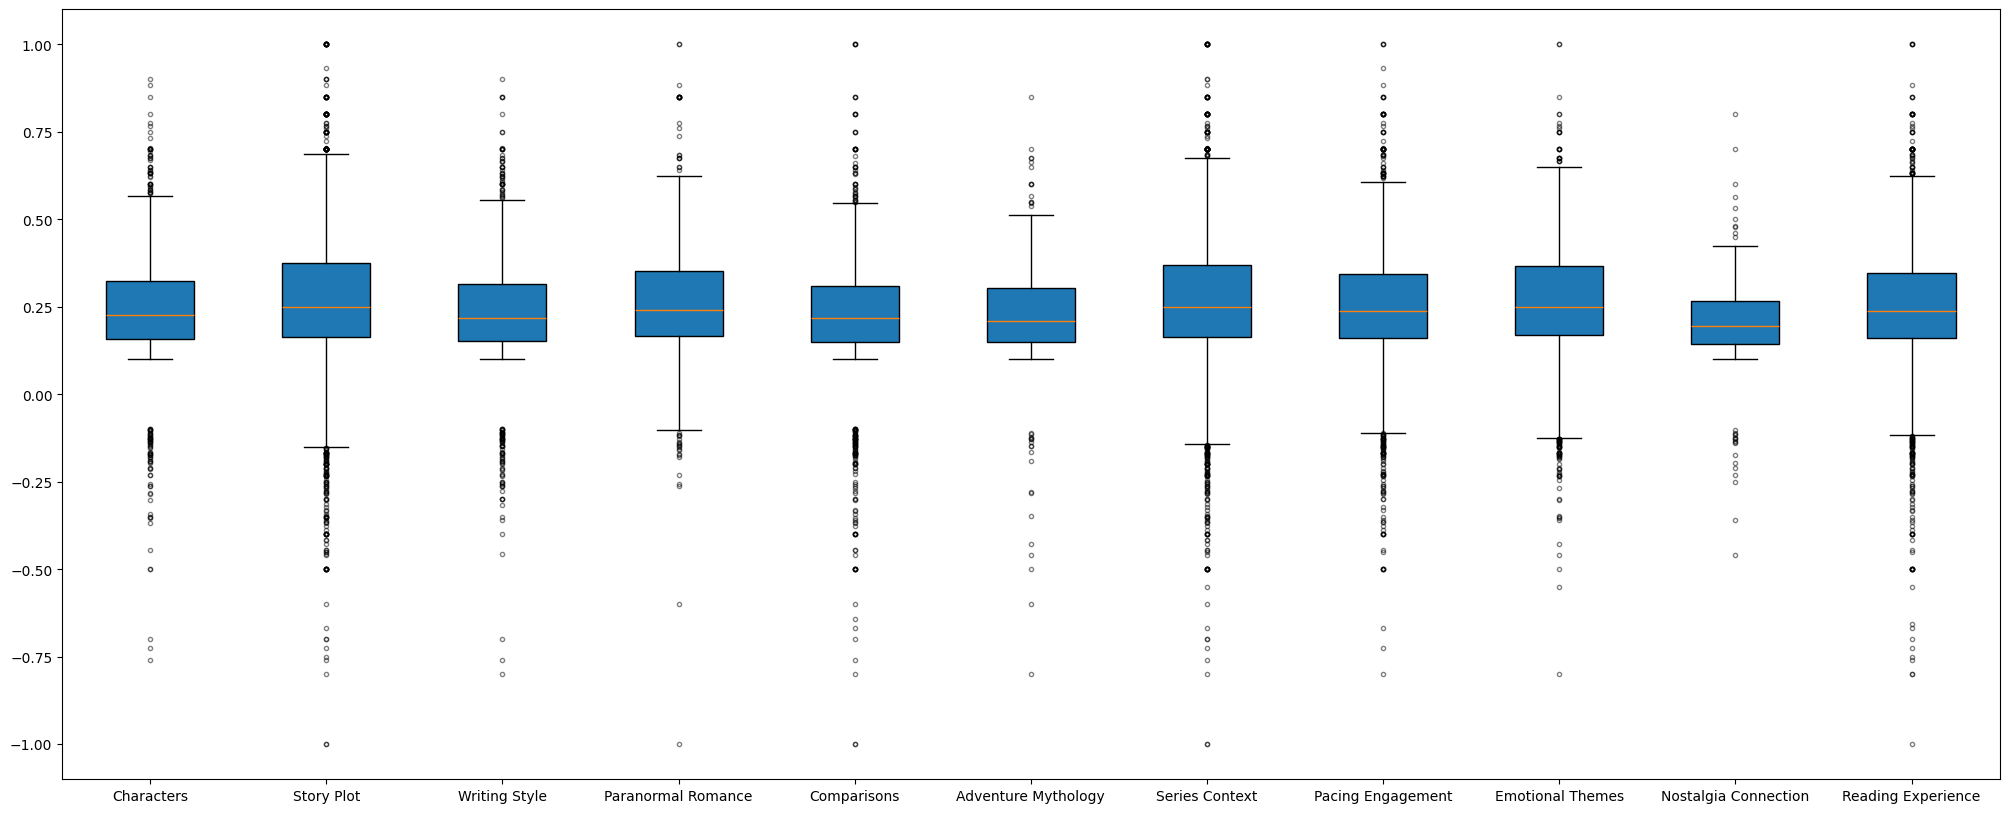

In [ ]:
# Create figure
fig, ax = plt.subplots(figsize=(25, 10))

# Create boxplot
bp = ax.boxplot(sentiment_data,
                labels=aspect_names,
                patch_artist=True,  # Fill boxes with color
                showfliers=True,    # Show outliers
                flierprops={'marker': 'o', 'markersize': 3, 'alpha': 0.5})

#### Sentiment Stats

In [ ]:
print(f"\nSentiment Statistics:")
print("-" * 40)

for i, (aspect, data) in enumerate(zip(aspect_names, sentiment_data)):
    mean_val = np.mean(data)
    median_val = np.median(data)
    positive_pct = (data > 0.1).mean() * 100
    negative_pct = (data < -0.1).mean() * 100

    print(f"{aspect}:")
    print(f"   Count: {len(data):,}")
    print(f"   Mean: {mean_val:+.3f}")
    print(f"   Median: {median_val:+.3f}")
    print(f"   Positive: {positive_pct:.1f}%")
    print(f"   Negative: {negative_pct:.1f}%")
    print()

# Show plot
plt.show()


Sentiment Statistics:
----------------------------------------
Characters:
   Count: 1,499
   Mean: +0.243
   Median: +0.225
   Positive: 95.3%
   Negative: 4.4%

Story Plot:
   Count: 2,956
   Mean: +0.264
   Median: +0.250
   Positive: 92.5%
   Negative: 7.0%

Writing Style:
   Count: 1,354
   Mean: +0.234
   Median: +0.219
   Positive: 94.2%
   Negative: 5.3%

Paranormal Romance:
   Count: 635
   Mean: +0.272
   Median: +0.240
   Positive: 96.5%
   Negative: 3.5%

Comparisons:
   Count: 1,578
   Mean: +0.220
   Median: +0.218
   Positive: 91.8%
   Negative: 7.6%

Adventure Mythology:
   Count: 269
   Mean: +0.221
   Median: +0.211
   Positive: 92.9%
   Negative: 7.1%

Series Context:
   Count: 2,789
   Mean: +0.263
   Median: +0.250
   Positive: 92.8%
   Negative: 6.7%

Pacing Engagement:
   Count: 2,116
   Mean: +0.254
   Median: +0.237
   Positive: 94.3%
   Negative: 5.4%

Emotional Themes:
   Count: 2,300
   Mean: +0.270
   Median: +0.250
   Positive: 95.9%
   Negative: 3.7%

No

### Keyword Extraction

In [ ]:
df = pd.read_parquet("/content/drive/MyDrive/APAN 5430 NLP Group Project/Goodreads/data/goodreads_absa.parquet")

In [ ]:
df.columns

Index(['book_id', 'review_text', 'rating', 'date_added', 'read_at',
       'started_at', 'user_id', 'n_votes', 'n_comments', 'title',
       'title_without_series', 'authors', 'publisher', 'average_rating',
       'ratings_count', 'text_reviews_count', 'description', 'popular_shelves',
       'similar_books', 'language_code', 'format', 'clean_review', 'id',
       'topic', 'topic_prob', 'topic_prob_max', 'topic_0_prob', 'topic_1_prob',
       'topic_2_prob', 'characters_sentiment', 'characters_mentions',
       'characters_keywords', 'story_plot_sentiment', 'story_plot_mentions',
       'story_plot_keywords', 'writing_style_sentiment',
       'writing_style_mentions', 'writing_style_keywords',
       'paranormal_romance_sentiment', 'paranormal_romance_mentions',
       'paranormal_romance_keywords', 'comparisons_sentiment',
       'comparisons_mentions', 'comparisons_keywords',
       'adventure_mythology_sentiment', 'adventure_mythology_mentions',
       'adventure_mythology_keywords'

#### Vectorizer

In [ ]:
# Fit TF-IDF vectorizer on all clean reviews
vectorizer = TfidfVectorizer(stop_words='english', ngram_range=(1, 2))  # unigrams + bigrams
vectorizer.fit(df['clean_review'])
tfidf_matrix = vectorizer.transform(df['clean_review'])

#### Keyword Extraction

In [ ]:
# Enhanced keyword exctraction function
def enhanced_keywords_per_review(text, vectorizer, topic_keywords=None, aspect_sentiment=None, top_n=5):

    # Base TF-IDF scores
    tfidf_vector = vectorizer.transform([text])
    scores = tfidf_vector.toarray().flatten()
    terms = vectorizer.get_feature_names_out()

    # Create enhanced scores by incorporating topic and sentiment context
    enhanced_scores = scores.copy()

    # Boost keywords that appear in the topic model for this review's topic
    if topic_keywords:
        for i, term in enumerate(terms):
            if any(keyword in term or term in keyword for keyword in topic_keywords):
                enhanced_scores[i] *= 1.5  # Boost topic-relevant terms

    # Boost keywords related to aspects with strong sentiment
    if aspect_sentiment:
        for aspect, sentiment_score in aspect_sentiment.items():
            # Boost terms related to aspects with strong positive or negative sentiment
            if abs(sentiment_score) > 0.3:  # Strong sentiment threshold
                for i, term in enumerate(terms):
                    if aspect.lower() in term or any(word in term for word in aspect.lower().split()):
                        # Boost more for stronger sentiment
                        boost_factor = 1 + abs(sentiment_score)
                        enhanced_scores[i] *= boost_factor

    # Get top keywords based on enhanced scores
    top_indices = enhanced_scores.argsort()[::-1][:top_n]
    keywords = [terms[i] for i in top_indices if enhanced_scores[i] > 0]

    # Return keywords with their context
    keyword_context = []
    for keyword in keywords:
        context = {"keyword": keyword, "tfidf_score": scores[terms.tolist().index(keyword)]}

        # Add topic relevance flag
        if topic_keywords and any(tk in keyword or keyword in tk for tk in topic_keywords):
            context["topic_relevant"] = True

        # Add aspect sentiment info
        if aspect_sentiment:
            for aspect, sentiment in aspect_sentiment.items():
                if aspect.lower() in keyword:
                    context["aspect"] = aspect
                    context["sentiment"] = sentiment
                    break

        keyword_context.append(context)

    return keyword_context

In [ ]:
# Topic-aware keyword extraction
# Topic keywords from BERTopic results (Topic_Modeling.ipynb)
TOPIC_KEYWORDS = {
    0: ["novel", "ya", "couldn", "beautiful", "character", "story", "fairy", "tale", "book", "read", "love", "sweet", "innocent", "romance"],
    1: ["rise", "blood", "court", "angel", "twilight", "vampire", "supernatural", "romance", "paranormal", "bella", "edward", "immortal"],
    2: ["hero", "camp", "chase", "humor", "percy", "jackson", "mythology", "god", "demigod", "riordan", "adventure", "olympus"]
}


def get_topic_keywords_for_review(review_topic, topic_model=None):

    # Handle noise topic
    if review_topic == -1:
        return []

    # Use predefined keywords
    topic_keywords = TOPIC_KEYWORDS.get(review_topic, [])

    # Dynamic extraction from BERTopic model
    if topic_model is not None:
        try:
            # Get top words for the topic from the actual model
            topic_words = topic_model.get_topic(review_topic)
            if topic_words:
                # Extract just the words (not scores) and take top 10
                dynamic_keywords = [word for word, score in topic_words[:10]]
                # Combine with predefined keywords for robustness
                topic_keywords = list(set(topic_keywords + dynamic_keywords))
        except:
            # Fallback to predefined if model access fails
            pass

    return topic_keywords

def get_aspect_sentiment_for_review(row):

    aspect_sentiment = {}

    # ABSA aspects
    aspects = [
        'characters', 'story_plot', 'writing_style', 'paranormal_romance',
        'comparisons', 'adventure_mythology', 'series_context',
        'pacing_engagement', 'emotional_themes', 'nostalgia_connection',
        'reading_experience'
    ]

    for aspect in aspects:
        sentiment_col = f"{aspect}_sentiment"
        if sentiment_col in row.index and pd.notna(row[sentiment_col]):
            aspect_sentiment[aspect] = row[sentiment_col]

    return aspect_sentiment

In [ ]:
# Add the missing enhanced_keywords_per_review function
def enhanced_keywords_per_review(text, vectorizer, topic_keywords=None, aspect_sentiment=None, top_n=5):
    """
    Enhanced keyword extraction with topic and aspect weighting
    """
    if not text or pd.isna(text):
        return []

    # Get TF-IDF vector for this review
    tfidf_vector = vectorizer.transform([text])
    scores = tfidf_vector.toarray().flatten()
    terms = vectorizer.get_feature_names_out()

    # Create keyword candidates with scores
    keyword_candidates = []

    for i, score in enumerate(scores):
        if score > 0:  # Only consider terms that appear in the review
            term = terms[i]
            enhanced_score = score
            is_topic_relevant = False
            related_aspect = None

            # Boost score if term is topic-relevant
            if topic_keywords and any(keyword in term for keyword in topic_keywords):
                enhanced_score *= 1.5  # 50% boost for topic relevance
                is_topic_relevant = True

            # Boost score if term relates to positively-sentiment aspects
            if aspect_sentiment:
                for aspect, sentiment in aspect_sentiment.items():
                    # Simple check if term relates to aspect
                    if sentiment > 0.1 and aspect.replace('_', ' ') in term:
                        enhanced_score *= 1.3  # 30% boost for positive aspects
                        related_aspect = aspect
                        break

            keyword_data = {
                'keyword': term,
                'tfidf_score': score,
                'enhanced_score': enhanced_score,
                'topic_relevant': is_topic_relevant
            }

            if related_aspect:
                keyword_data['aspect'] = related_aspect
                keyword_data['sentiment'] = aspect_sentiment[related_aspect]

            keyword_candidates.append(keyword_data)

    # Sort by enhanced score and return top N
    keyword_candidates.sort(key=lambda x: x['enhanced_score'], reverse=True)

    # Return top keywords with minimal structure
    result = []
    for kw in keyword_candidates[:top_n]:
        item = {
            'keyword': kw['keyword'],
            'tfidf_score': kw['tfidf_score']
        }
        if kw['topic_relevant']:
            item['topic_relevant'] = True
        if 'aspect' in kw:
            item['aspect'] = kw['aspect']
            item['sentiment'] = kw['sentiment']
        result.append(item)

    return result

In [ ]:
# Apply enhanced keyword extraction
def apply_enhanced_keywords(row):

    # Get topic keywords (from BERTopic results)
    topic_keywords = get_topic_keywords_for_review(
        row.get('topic', -1),  # Use -1 as default for noise topic
    )

    #  Get aspect sentiment from ABSA columns
    aspect_sentiment = get_aspect_sentiment_for_review(row)

    # Extract enhanced keywords
    enhanced_keywords = enhanced_keywords_per_review(
        row['clean_review'],
        vectorizer,
        topic_keywords=topic_keywords,
        aspect_sentiment=aspect_sentiment,
        top_n=5
    )

    return enhanced_keywords

In [ ]:
# Apply to dataframe
df['enhanced_keywords'] = df.apply(apply_enhanced_keywords, axis=1)

# Also keep the original simple keyword extraction for comparison
def simple_top_keywords_per_review(text, vectorizer, top_n=5):
    """Original simple keyword extraction function"""
    tfidf_vector = vectorizer.transform([text])
    scores = tfidf_vector.toarray().flatten()
    top_indices = scores.argsort()[::-1][:top_n]
    terms = vectorizer.get_feature_names_out()
    return [terms[i] for i in top_indices if scores[i] > 0]

df['basic_keywords'] = df['clean_review'].apply(
    lambda x: simple_top_keywords_per_review(x, vectorizer)
)

In [ ]:
# Now df has a new column 'top_keywords' with a list of top keywords per review
df[['clean_review', 'basic_keywords', 'enhanced_keywords']].head()

,clean_review,basic_keywords,enhanced_keywords
0,book brian smart kid lot smart plane crash can...,"[smart, smart plane, writing adventure, kid lo...","[{'keyword': 'book brian', 'tfidf_score': 0.22..."
1,read book probably dozen time grow probably re...,"[brian, canadian, task, wilderness, step]","[{'keyword': 'brian', 'tfidf_score': 0.3169480..."
2,read high school enjoy reread audio pretty good,"[audio pretty, enjoy reread, reread audio, sch...","[{'keyword': 'enjoy reread', 'tfidf_score': 0...."
3,understand book draw boy like hole find presup...,"[brian, wilderness, plane, appeal universal, b...","[{'keyword': 'brian', 'tfidf_score': 0.2714701..."
4,bad didn read kid judging time read boy scout ...,"[grab way, bet love, handbook bet, kid judging...","[{'keyword': 'bet love', 'tfidf_score': 0.2304..."


In [ ]:
# full enhanced keyword structure for 1 review
print(df.iloc[0]['enhanced_keywords'])

[{'keyword': 'book brian', 'tfidf_score': np.float64(0.2232378668488068), 'topic_relevant': True}, {'keyword': 'smart', 'tfidf_score': np.float64(0.2745952553396138)}, {'keyword': 'adventure suspense', 'tfidf_score': np.float64(0.2341086456418198)}, {'keyword': 'brian smart', 'tfidf_score': np.float64(0.2341086456418198)}, {'keyword': 'crash canadian', 'tfidf_score': np.float64(0.2341086456418198)}]


In [ ]:
# list format for similarity search
def extract_keywords_simple(enhanced_keywords_list):

    if not enhanced_keywords_list or not isinstance(enhanced_keywords_list, list):
        return []

    try:
        # Extract just the keyword strings
        simple_keywords = []
        for item in enhanced_keywords_list:
            if isinstance(item, dict) and 'keyword' in item:
                simple_keywords.append(item['keyword'])
            elif isinstance(item, str):
                simple_keywords.append(item)

        return simple_keywords
    except:
        # Fallback if there's any issue with the format
        return []

In [ ]:
def extract_keywords_with_context(enhanced_keywords_list):

    if not enhanced_keywords_list or not isinstance(enhanced_keywords_list, list):
        return {'keywords': [], 'topic_relevant': [], 'aspect_keywords': []}

    try:
        result = {
            'keywords': [],
            'topic_relevant': [],
            'aspect_keywords': [],
            'scores': []
        }

        for item in enhanced_keywords_list:
            if isinstance(item, dict) and 'keyword' in item:
                keyword = item['keyword']
                result['keywords'].append(keyword)
                result['scores'].append(item.get('tfidf_score', 0))

                # Track which keywords are topic-relevant
                if item.get('topic_relevant', False):
                    result['topic_relevant'].append(keyword)

                # Track which keywords are aspect-related
                if 'aspect' in item:
                    result['aspect_keywords'].append({
                        'keyword': keyword,
                        'aspect': item['aspect'],
                        'sentiment': item.get('sentiment', 0)
                    })

        return result
    except:
        return {'keywords': [], 'topic_relevant': [], 'aspect_keywords': []}


In [ ]:
# Apply the conversion to dataframe
# Create simple keyword list for compatibility with similarity functions
df['keywords_simple'] = df['enhanced_keywords'].apply(extract_keywords_simple)

In [ ]:
# Create context-rich version for detailed analysis
df['keywords_context'] = df['enhanced_keywords'].apply(extract_keywords_with_context)

# Create a string version for potential text-based similarity
df['keywords_text'] = df['keywords_simple'].apply(lambda x: ' '.join(x) if x else '')

In [ ]:
# Results
for i in range(3):
    print(f"\nRow {i}:")
    print(f"Enhanced (original): {df.iloc[i]['enhanced_keywords']}")
    print(f"Simple: {df.iloc[i]['keywords_simple']}")
    print(f"Text: '{df.iloc[i]['keywords_text']}'")

    # Show context if available
    context = df.iloc[i]['keywords_context']
    if context['topic_relevant']:
        print(f"Topic-relevant keywords: {context['topic_relevant']}")
    if context['aspect_keywords']:
        print(f"Aspect keywords: {context['aspect_keywords']}")


Row 0:
Enhanced (original): [{'keyword': 'book brian', 'tfidf_score': np.float64(0.2232378668488068), 'topic_relevant': True}, {'keyword': 'smart', 'tfidf_score': np.float64(0.2745952553396138)}, {'keyword': 'adventure suspense', 'tfidf_score': np.float64(0.2341086456418198)}, {'keyword': 'brian smart', 'tfidf_score': np.float64(0.2341086456418198)}, {'keyword': 'crash canadian', 'tfidf_score': np.float64(0.2341086456418198)}]
Simple: ['book brian', 'smart', 'adventure suspense', 'brian smart', 'crash canadian']
Text: 'book brian smart adventure suspense brian smart crash canadian'
Topic-relevant keywords: ['book brian']

Row 1:
Enhanced (original): [{'keyword': 'brian', 'tfidf_score': np.float64(0.3169480981118678)}, {'keyword': 'canadian', 'tfidf_score': np.float64(0.16883181950883702)}, {'keyword': 'task', 'tfidf_score': np.float64(0.16778697991071673)}, {'keyword': 'wilderness', 'tfidf_score': np.float64(0.14894400694906262)}, {'keyword': 'book', 'tfidf_score': np.float64(0.097517

In [ ]:
df.to_parquet("/content/drive/MyDrive/APAN 5430 NLP Group Project/Goodreads/data/goodreads_keywords.parquet")

In [ ]:
df.columns

Index(['book_id', 'review_text', 'rating', 'date_added', 'read_at',
       'started_at', 'user_id', 'n_votes', 'n_comments', 'title',
       'title_without_series', 'authors', 'publisher', 'average_rating',
       'ratings_count', 'text_reviews_count', 'description', 'popular_shelves',
       'similar_books', 'language_code', 'format', 'clean_review', 'id',
       'topic', 'topic_prob', 'topic_prob_max', 'topic_0_prob', 'topic_1_prob',
       'topic_2_prob', 'characters_sentiment', 'characters_mentions',
       'characters_keywords', 'story_plot_sentiment', 'story_plot_mentions',
       'story_plot_keywords', 'writing_style_sentiment',
       'writing_style_mentions', 'writing_style_keywords',
       'paranormal_romance_sentiment', 'paranormal_romance_mentions',
       'paranormal_romance_keywords', 'comparisons_sentiment',
       'comparisons_mentions', 'comparisons_keywords',
       'adventure_mythology_sentiment', 'adventure_mythology_mentions',
       'adventure_mythology_keywords'

### Cosine Similarity

In [ ]:
df = pd.read_parquet("/content/drive/MyDrive/APAN 5430 NLP Group Project/Goodreads/data/goodreads_keywords.parquet")

In [ ]:
# Fit TF-IDF vectorizer
vectorizer = TfidfVectorizer(stop_words='english', ngram_range=(1, 2))  # unigrams + bigrams
vectorizer.fit(df['clean_review'])
tfidf_matrix = vectorizer.transform(df['clean_review'])

In [ ]:
# Recommendation function with similarity
def recommend_books_enhanced(user_input, df, vectorizer, tfidf_matrix, top_n=5,
                           aspect=None, topic_filter=None):

    from sklearn.metrics.pairwise import cosine_similarity

    user_vec = vectorizer.transform([user_input])
    similarities = cosine_similarity(user_vec, tfidf_matrix).flatten() # cosine similarity

    df_work = df.copy()
    df_work['similarity'] = similarities

    # Simple topic filtering
    if topic_filter is not None:
        df_work = df_work[df_work['topic'] == topic_filter]

    # Simple aspect filtering
    if aspect:
        aspect_col = f"{aspect}_sentiment"
        if aspect_col in df_work.columns:
            df_work = df_work[df_work[aspect_col] > 0]  # Basic positive filter

    # Return early if no matches
    if len(df_work) == 0:
        return []

    # Group by book_id and title
    book_scores = df_work.groupby(['book_id', 'title'])['similarity'].max().reset_index()
    top_books = book_scores.sort_values('similarity', ascending=False).head(top_n)

    # Build results (enhanced with topic/aspect info but keeping simple structure)
    results = []
    for _, row in top_books.iterrows():
        book_reviews = df_work[(df_work['book_id'] == row['book_id']) &
                              (df_work['similarity'] == row['similarity'])]
        best_review = book_reviews.iloc[0]

        result = {
            'book_id': row['book_id'],
            'title': row['title'],
            'score': row['similarity'],
            'top_review_snippet': best_review['clean_review'][:200] + '...',
        }

        # Add enhanced keywords (the main improvement!)
        result['keywords'] = best_review.get('keywords_simple', [])  # Enhanced keywords in simple format
        result['basic_keywords'] = best_review.get('basic_keywords', [])  # Original for comparison

        # Add minimal topic/aspect context (just the essentials)
        if 'topic' in best_review:
            result['topic'] = best_review['topic']

        if aspect and f"{aspect}_sentiment" in best_review:
            result[f'{aspect}_sentiment'] = best_review[f"{aspect}_sentiment"]

        results.append(result)

    return results

In [ ]:
# Test keywords
def test_enhanced_vs_basic():

    # Test queries aligned with 3 topics
    test_queries = [
        # Topic 0: YA General Fiction
        "I want a sweet innocent YA romance with beautiful fairy tale story and great characters",

        # Topic 1: Paranormal Romance
        "Looking for vampire romance like Twilight with supernatural elements and immortal love story",

        # Topic 2: Adventure/Mythology
        "I love Percy Jackson style books with mythology gods demigods and adventure at camp"
    ]

    for query_idx, test_query in enumerate(test_queries):
        print(f"\n{'='*80}")
        print(f"TEST QUERY {query_idx + 1}: {test_query}")
        print(f"{'='*80}")

        # Get recommendations
        results = recommend_books_enhanced(test_query, df, vectorizer, tfidf_matrix, top_n=3)

        for i, rec in enumerate(results, 1):
            print(f"\n{i}. {rec['title']}")
            print(f"   Score: {rec['score']:.3f} | Topic: {rec.get('topic', 'N/A')}")

            enhanced_kw = rec.get('keywords', [])
            basic_kw = rec.get('basic_keywords', [])

            print(f"   Enhanced Keywords: {enhanced_kw[:5]}")  # Show top 5
            print(f"   Basic Keywords:    {basic_kw[:5]}")
            print(f"   Snippet: {rec['top_review_snippet'][:100]}...")

            # Topic-specific relevance scoring based on actual topics
            if query_idx == 0:  # YA General
                relevant_terms = ['ya', 'romance', 'character', 'story', 'sweet', 'innocent', 'fairy', 'tale', 'beautiful']
            elif query_idx == 1:  # Paranormal Romance
                relevant_terms = ['vampire', 'twilight', 'supernatural', 'romance', 'immortal', 'bella', 'edward', 'paranormal']
            elif query_idx == 2:  # Adventure/Mythology
                relevant_terms = ['percy', 'jackson', 'mythology', 'god', 'demigod', 'adventure', 'camp', 'hero']

            # Count query-relevant matches
            enhanced_matches = sum(1 for kw in enhanced_kw if any(term in kw.lower() for term in relevant_terms))
            basic_matches = sum(1 for kw in basic_kw if any(term in kw.lower() for term in relevant_terms))

            print(f"   Query-relevant terms: Enhanced({enhanced_matches}) vs Basic({basic_matches})")

            # Show topic alignment
            expected_topic = query_idx  # Query 0 -> Topic 0, etc.
            actual_topic = rec.get('topic', -1)
            topic_match = "✓" if actual_topic == expected_topic else "✗"
            print(f"   Topic alignment: {topic_match} (Expected: {expected_topic}, Got: {actual_topic})")


In [ ]:
# Test aspect filtering
def test_aspect_filtering():

    # Test queries with specific aspect preferences
    aspect_tests = [
        {
            'query': "I want books with great character development",
            'aspect': 'characters',
            'description': 'Character-focused recommendations'
        },
        {
            'query': "Looking for books with exciting adventure and fast pacing",
            'aspect': 'pacing_engagement',
            'description': 'Pacing-focused recommendations'
        },
        {
            'query': "I love paranormal romance with supernatural elements",
            'aspect': 'paranormal_romance',
            'description': 'Genre-specific recommendations'
        }
    ]

    for test in aspect_tests:
        print(f"\nTEST: {test['description']}")
        print(f"Query: '{test['query']}'")
        print(f"Filtering by aspect: {test['aspect']}")

        # Get recommendations with aspect filtering
        results = recommend_books_enhanced(
            test['query'],
            df,
            vectorizer,
            tfidf_matrix,
            top_n=3,
            aspect=test['aspect']
        )

        if results:
            for i, rec in enumerate(results, 1):
                aspect_sentiment = rec.get(f"{test['aspect']}_sentiment", 'N/A')
                print(f"   {i}. {rec['title']} (Score: {rec['score']:.3f}, {test['aspect']}: {aspect_sentiment})")
        else:
            print("   No books found with positive sentiment for this aspect")

        print("-" * 60)

# Run both tests
print("\n\nENHANCED KEYWORD TEST")
test_enhanced_vs_basic()

print("\n\nASPECT FILTERING TEST")
test_aspect_filtering()



ENHANCED KEYWORD TEST

TEST QUERY 1: I want a sweet innocent YA romance with beautiful fairy tale story and great characters

1. By Your Side
   Score: 0.684 | Topic: 0
   Enhanced Keywords: ['innocent ya' 'sweet innocent' 'ya romance' 'innocent' 'sweet']
   Basic Keywords:    ['innocent ya' 'sweet innocent' 'ya romance' 'innocent' 'sweet']
   Snippet: sweet innocent ya romance......
   Query-relevant terms: Enhanced(5) vs Basic(5)
   Topic alignment: ✓ (Expected: 0, Got: 0)

2. UnEnchanted (An Unfortunate Fairy Tale, #1)
   Score: 0.284 | Topic: 0
   Enhanced Keywords: ['fairy tale' 'fairy' 'tale' 'tale story' 'adaptation book']
   Basic Keywords:    ['fairy tale' 'fairy' 'tale' 'tale story' 'integrate mina']
   Snippet: interesting fresh fairy tale story unenchante take popular fairy tale story add modern twist integra...
   Query-relevant terms: Enhanced(4) vs Basic(4)
   Topic alignment: ✓ (Expected: 0, Got: 0)

3. The Fill-In Boyfriend
   Score: 0.186 | Topic: 0
   Enhanced Keyw

In [ ]:
def smart_recommend(user_input, df, vectorizer, tfidf_matrix, top_n=5):

    # Simple topic detection based on TOPIC_KEYWORDS
    query_lower = user_input.lower()

    topic_filter = None
    detected_topic_name = None

    # Topic 0: YA General Fiction
    if any(word in query_lower for word in ['ya', 'sweet', 'innocent', 'romance', 'fairy tale', 'beautiful', 'novel']):
        topic_filter = 0
        detected_topic_name = "YA General Fiction"
    # Topic 1: Paranormal Romance
    elif any(word in query_lower for word in ['vampire', 'twilight', 'supernatural', 'paranormal', 'bella', 'edward', 'immortal']):
        topic_filter = 1
        detected_topic_name = "Paranormal Romance"
    # Topic 2: Adventure/Mythology
    elif any(word in query_lower for word in ['percy', 'jackson', 'mythology', 'demigod', 'gods', 'camp', 'adventure', 'hero']):
        topic_filter = 2
        detected_topic_name = "Adventure/Mythology"

    # Simple aspect detection based on cleaned ABSA aspects
    aspect = None
    detected_aspect_name = None

    if any(word in query_lower for word in ['character', 'protagonist', 'development', 'hero', 'heroine']):
        aspect = 'characters'
        detected_aspect_name = "Character Development"
    elif any(word in query_lower for word in ['plot', 'story', 'storyline', 'narrative', 'tale']):
        aspect = 'story_plot'
        detected_aspect_name = "Story/Plot"
    elif any(word in query_lower for word in ['writing', 'author', 'style', 'prose']):
        aspect = 'writing_style'
        detected_aspect_name = "Writing Style"
    elif any(word in query_lower for word in ['vampire', 'supernatural', 'magic', 'paranormal']):
        aspect = 'paranormal_romance'
        detected_aspect_name = "Paranormal Elements"
    elif any(word in query_lower for word in ['mythology', 'gods', 'demigod', 'adventure']):
        aspect = 'adventure_mythology'
        detected_aspect_name = "Adventure/Mythology"
    elif any(word in query_lower for word in ['series', 'sequel', 'continue', 'next book']):
        aspect = 'series_context'
        detected_aspect_name = "Series Context"
    elif any(word in query_lower for word in ['fast', 'slow', 'pacing', 'engaging', 'exciting']):
        aspect = 'pacing_engagement'
        detected_aspect_name = "Pacing/Engagement"
    elif any(word in query_lower for word in ['emotional', 'feel', 'love', 'romance']):
        aspect = 'emotional_themes'
        detected_aspect_name = "Emotional Themes"

    # Print detections
    if topic_filter is not None:
        print(f" Detected topic: {topic_filter} ({detected_topic_name})")
    if aspect:
        print(f" Detected aspect: {aspect} ({detected_aspect_name})")

    if topic_filter is None and aspect is None:
        print("💡 No specific topic/aspect detected - using general similarity")

    return recommend_books_enhanced(
        user_input, df, vectorizer, tfidf_matrix,
        top_n=top_n, topic_filter=topic_filter, aspect=aspect
    )


In [ ]:
def analyze_similarity_scores():
# similarity scores
    # Test queries aligned with topics
    test_queries = [
        "sweet innocent YA romance with beautiful fairy tale story",  # Topic 0
        "vampire romance like twilight with supernatural elements",   # Topic 1
        "percy jackson mythology adventure with gods and demigods",   # Topic 2
        "books with great character development and emotional story"  # Multi-aspect
    ]

    for i, query in enumerate(test_queries, 1):
        print(f"\n{'='*80}")
        print(f"QUERY {i}: {query}")
        print(f"{'='*80}")

        # Calculate similarity scores
        user_vec = vectorizer.transform([query])
        similarities = cosine_similarity(user_vec, tfidf_matrix).flatten()

        # Add to dataframe
        df_temp = df.copy()
        df_temp['similarity_score'] = similarities

        # Show top 10 matches
        print(f"\nTop 10 matches:")
        top_matches = df_temp.nlargest(10, 'similarity_score')[['title', 'similarity_score', 'topic', 'clean_review']]

        for j, (_, row) in enumerate(top_matches.iterrows(), 1):
            title_truncated = row['title'][:40] + "..." if len(row['title']) > 40 else row['title']
            print(f"{j:2d}. {title_truncated:45} | Score: {row['similarity_score']:.3f} | Topic: {row['topic']}")

        # Enhanced statistics
        above_01 = sum(similarities > 0.1)
        above_02 = sum(similarities > 0.2)
        above_03 = sum(similarities > 0.3)

        print(f"\n Score Statistics:")
        print(f"   Max: {similarities.max():.3f} | Mean: {similarities.mean():.3f} | Std: {similarities.std():.3f}")
        print(f"   Above 0.1: {above_01} | Above 0.2: {above_02} | Above 0.3: {above_03}")

        # Topic distribution of top matches
        top_10_topics = top_matches['topic'].value_counts()
        print(f"   Topic distribution in top 10: {dict(top_10_topics)}")


In [ ]:
def test_smart_recommendation():

    test_cases = [
        "I love Percy Jackson books with mythology and adventure",
        "Looking for vampire romance similar to Twilight",
        "Want sweet YA romance with good character development",
        "Books with fast pacing and exciting plot",
        "Emotional fantasy series with strong characters"
    ]

    for i, query in enumerate(test_cases, 1):
        print(f"\nTest {i}: '{query}'")
        print("-" * 50)

        results = smart_recommend(query, df, vectorizer, tfidf_matrix, top_n=3)

        if results:
            for j, rec in enumerate(results, 1):
                print(f"   {j}. {rec['title']}")
                print(f"      Score: {rec['score']:.3f} | Topic: {rec.get('topic', 'N/A')}")
                print(f"      Keywords: {rec.get('keywords', [])[:3]}")  # Show top 3 keywords
        else:
            print("   No recommendations found")
        print()

In [ ]:
# Run the analysis
analyze_similarity_scores()


QUERY 1: sweet innocent YA romance with beautiful fairy tale story

Top 10 matches:
 1. By Your Side                                  | Score: 0.778 | Topic: 0
 2. UnEnchanted (An Unfortunate Fairy Tale, ...   | Score: 0.323 | Topic: 0
 3. UnEnchanted (An Unfortunate Fairy Tale, ...   | Score: 0.234 | Topic: 0
 4. The Fill-In Boyfriend                         | Score: 0.212 | Topic: 0
 5. Wintersong (Wintersong, #1)                   | Score: 0.190 | Topic: 0
 6. The Geography of You and Me                   | Score: 0.177 | Topic: 0
 7. The DUFF: Designated Ugly Fat Friend          | Score: 0.176 | Topic: 0
 8. Entwined                                      | Score: 0.166 | Topic: 0
 9. Beastly (Beastly, #1; Kendra Chronicles,...   | Score: 0.160 | Topic: 0
10. Entwined                                      | Score: 0.150 | Topic: 0

 Score Statistics:
   Max: 0.778 | Mean: 0.006 | Std: 0.018
   Above 0.1: 16 | Above 0.2: 4 | Above 0.3: 2
   Topic distribution in top 10: {0: np.int64(1

In [ ]:
test_smart_recommendation()


Test 1: 'I love Percy Jackson books with mythology and adventure'
--------------------------------------------------
 Detected topic: 2 (Adventure/Mythology)
 Detected aspect: adventure_mythology (Adventure/Mythology)
   1. The House of Hades (The Heroes of Olympus, #4)
      Score: 0.768 | Topic: 2
      Keywords: ['jackson books' 'love percy' 'percy jackson']
   2. The Sword of Summer (Magnus Chase and the Gods of Asgard, #1)
      Score: 0.321 | Topic: 2
      Keywords: ['percy jackson' 'jackson' 'percy']
   3. The Battle of the Labyrinth (Percy Jackson and the Olympians, #4)
      Score: 0.282 | Topic: 2
      Keywords: ['percy' 'grow percy' 'percy character']


Test 2: 'Looking for vampire romance similar to Twilight'
--------------------------------------------------
 Detected topic: 0 (YA General Fiction)
 Detected aspect: paranormal_romance (Paranormal Elements)
   1. The Immortal Rules (Blood of Eden, #1)
      Score: 0.094 | Topic: 0
      Keywords: ['allie' 'vampire' 'immor

In [ ]:
print(f"Minimum: {df['similarity_score'].min():.6f}")
print(f"Maximum: {df['similarity_score'].max():.6f}")

Minimum: 0.000000
Maximum: 0.778481


In [ ]:
# Enhanced similarity analysis with ABSA and topics
query = "sweet innocent YA romance with beautiful fairy tale story"
print(f"Query: '{query}'")

# Calculate similarity scores
user_vec = vectorizer.transform([query])
similarities = cosine_similarity(user_vec, tfidf_matrix).flatten()
df['similarity_score'] = similarities

# Create enhanced view with ABSA and topics
print("\nTop 10 matches with ABSA aspects and topics:")
print("-" * 120)

cols_to_show = ['title', 'similarity_score', 'topic',
                'characters_sentiment', 'story_plot_sentiment', 'writing_style_sentiment',
                'paranormal_romance_sentiment', 'comparisons_sentiment', 'adventure_mythology_sentiment',
                'series_context_sentiment', 'pacing_engagement_sentiment', 'emotional_themes_sentiment',
                'nostalgia_connection_sentiment', 'reading_experience_sentiment', 'keywords_simple']

top_matches = df.nlargest(10, 'similarity_score')[cols_to_show]

for i, (_, row) in enumerate(top_matches.iterrows(), 1):
    print(f"{i:2d}. {row['title'][:40]:40} | Score: {row['similarity_score']:.3f} | Topic: {row['topic']}")

    # Core aspects
    print(f"    Characters: {row['characters_sentiment']:5.2f} | Plot: {row['story_plot_sentiment']:5.2f} | Writing: {row['writing_style_sentiment']:5.2f}")

    # Genre-specific aspects
    print(f"    Paranormal: {row['paranormal_romance_sentiment']:5.2f} | Adventure: {row['adventure_mythology_sentiment']:5.2f} | Comparisons: {row['comparisons_sentiment']:5.2f}")

    # Experience aspects
    print(f"    Series: {row['series_context_sentiment']:5.2f} | Pacing: {row['pacing_engagement_sentiment']:5.2f} | Emotional: {row['emotional_themes_sentiment']:5.2f}")

    # Additional aspects
    print(f"    Nostalgia: {row['nostalgia_connection_sentiment']:5.2f} | Reading Exp: {row['reading_experience_sentiment']:5.2f}")

    print(f"    Keywords: {row['keywords_simple'][:5]}")
    print()

# Show topic distribution in top matches
print("Topic distribution in top 10:")
topic_counts = top_matches['topic'].value_counts()
topic_names = {0: "YA General Fiction", 1: "Paranormal Romance", 2: "Adventure/Mythology"}
for topic, count in topic_counts.items():
    print(f"  Topic {topic} ({topic_names.get(topic, 'Unknown')}): {count} books")

# Show average ABSA scores for ALL aspects in top matches
print(f"\nAverage ABSA scores for ALL aspects in top 10:")
print(f"  Characters sentiment: {top_matches['characters_sentiment'].mean():.3f}")
print(f"  Story/Plot sentiment: {top_matches['story_plot_sentiment'].mean():.3f}")
print(f"  Writing style: {top_matches['writing_style_sentiment'].mean():.3f}")
print(f"  Paranormal romance: {top_matches['paranormal_romance_sentiment'].mean():.3f}")
print(f"  Adventure/Mythology: {top_matches['adventure_mythology_sentiment'].mean():.3f}")
print(f"  Comparisons: {top_matches['comparisons_sentiment'].mean():.3f}")
print(f"  Series context: {top_matches['series_context_sentiment'].mean():.3f}")
print(f"  Pacing/Engagement: {top_matches['pacing_engagement_sentiment'].mean():.3f}")
print(f"  Emotional themes: {top_matches['emotional_themes_sentiment'].mean():.3f}")
print(f"  Nostalgia connection: {top_matches['nostalgia_connection_sentiment'].mean():.3f}")
print(f"  Reading experience: {top_matches['reading_experience_sentiment'].mean():.3f}")

Query: 'sweet innocent YA romance with beautiful fairy tale story'

Top 10 matches with ABSA aspects and topics:
------------------------------------------------------------------------------------------------------------------------
 1. By Your Side                             | Score: 0.778 | Topic: 0
    Characters:  0.00 | Plot:  0.00 | Writing:  0.00
    Paranormal:  0.00 | Adventure:  0.00 | Comparisons:  0.00
    Series:  0.00 | Pacing:  0.00 | Emotional:  0.42
    Nostalgia:  0.42 | Reading Exp:  0.00
    Keywords: ['innocent ya' 'sweet innocent' 'ya romance' 'innocent' 'sweet']

 2. UnEnchanted (An Unfortunate Fairy Tale,  | Score: 0.323 | Topic: 0
    Characters:  0.21 | Plot:  0.21 | Writing:  0.21
    Paranormal:  0.00 | Adventure:  0.00 | Comparisons:  0.21
    Series:  0.21 | Pacing:  0.21 | Emotional:  0.00
    Nostalgia:  0.00 | Reading Exp:  0.21
    Keywords: ['fairy tale' 'fairy' 'tale' 'tale story' 'adaptation book']

 3. UnEnchanted (An Unfortunate Fairy Tale,  | S

In [ ]:
# Examples
# Original
print("\n1. 'I want a sweet YA romance with strong characters and emotional story' ")
results = recommend_books_enhanced(
    "I want a sweet YA romance with strong characters and emotional story",
    df, vectorizer, tfidf_matrix, top_n=5
)
print(f"Found {len(results)} results")
for i, rec in enumerate(results[:3], 1):
    print(f"{i}. {rec['title']} (Score: {rec['score']:.3f})")

# With topic filtering - Paranormal Romance (Topic 1)
print("\n2. With topic filtering: 'vampire romance books like twilight'")
results = recommend_books_enhanced(
    "vampire romance books like twilight",
    df, vectorizer, tfidf_matrix,
    topic_filter=1,  # Paranormal Romance topic
    top_n=3
)
print(f"Found {len(results)} results")
for i, rec in enumerate(results, 1):
    print(f"{i}. {rec['title']} (Score: {rec['score']:.3f})")

# With topic filtering - Adventure/Mythology (Topic 2)
print("\n3. With topic filtering: 'percy jackson mythology adventure books'")
results = recommend_books_enhanced(
    "percy jackson mythology adventure books",
    df, vectorizer, tfidf_matrix,
    topic_filter=2,  # Adventure/Mythology topic
    top_n=3
)
print(f"Found {len(results)} results")
for i, rec in enumerate(results, 1):
    print(f"{i}. {rec['title']} (Score: {rec['score']:.3f})")

# With aspect filtering - Characters
print("\n4. With aspect filtering: 'books with amazing character development'")
results = recommend_books_enhanced(
    "books with amazing character development",
    df, vectorizer, tfidf_matrix,
    aspect='characters',  # Only positive character sentiment
    top_n=3
)
print(f"Found {len(results)} results")
for i, rec in enumerate(results, 1):
    print(f"{i}. {rec['title']} (Score: {rec['score']:.3f})")

# With aspect filtering - Story/Plot
print("\n5. With aspect filtering: 'books with engaging plot and great story'")
results = recommend_books_enhanced(
    "books with engaging plot and great story",
    df, vectorizer, tfidf_matrix,
    aspect='story_plot',  # Only positive plot sentiment
    top_n=3
)
print(f"Found {len(results)} results")
for i, rec in enumerate(results, 1):
    print(f"{i}. {rec['title']} (Score: {rec['score']:.3f})")

# With aspect filtering - Pacing/Engagement
print("\n6. With aspect filtering: 'fast paced exciting books'")
results = recommend_books_enhanced(
    "fast paced exciting books",
    df, vectorizer, tfidf_matrix,
    aspect='pacing_engagement',  # Only positive pacing sentiment
    top_n=3
)
print(f"Found {len(results)} results")
for i, rec in enumerate(results, 1):
    print(f"{i}. {rec['title']} (Score: {rec['score']:.3f})")

# Smart auto-detection - Topic 0 (YA General)
print("\n7. Smart auto-detection: 'I love sweet innocent YA romance with beautiful fairy tales'")
results = smart_recommend(
    "I love sweet innocent YA romance with beautiful fairy tales",
    df, vectorizer, tfidf_matrix, top_n=3
)
print(f"Found {len(results)} results")
for i, rec in enumerate(results, 1):
    print(f"{i}. {rec['title']} (Score: {rec['score']:.3f})")

# Smart auto-detection - Topic 1 (Paranormal Romance)
print("\n8. Smart auto-detection: 'I want vampire romance like Twilight with supernatural elements'")
results = smart_recommend(
    "I want vampire romance like Twilight with supernatural elements",
    df, vectorizer, tfidf_matrix, top_n=3
)
print(f"Found {len(results)} results")
for i, rec in enumerate(results, 1):
    print(f"{i}. {rec['title']} (Score: {rec['score']:.3f})")

# Smart auto-detection - Topic 2 (Adventure/Mythology)
print("\n9. Smart auto-detection: 'I love Percy Jackson style mythology books with gods and adventure'")
results = smart_recommend(
    "I love Percy Jackson style mythology books with gods and adventure",
    df, vectorizer, tfidf_matrix, top_n=3
)
print(f"Found {len(results)} results")
for i, rec in enumerate(results, 1):
    print(f"{i}. {rec['title']} (Score: {rec['score']:.3f})")

# Combined filtering - Topic + Aspect
print("\n10. Combined filtering: YA books with emotional themes")
results = recommend_books_enhanced(
    "YA romance with emotional story",
    df, vectorizer, tfidf_matrix,
    topic_filter=0,  # YA General Fiction
    aspect='emotional_themes',  # Positive emotional sentiment
    top_n=3
)
print(f"Found {len(results)} results")
for i, rec in enumerate(results, 1):
    print(f"{i}. {rec['title']} (Score: {rec['score']:.3f})")


1. 'I want a sweet YA romance with strong characters and emotional story' 
Found 5 results
1. The Geography of You and Me (Score: 0.377)
2. By Your Side (Score: 0.286)
3. The Fill-In Boyfriend (Score: 0.240)

2. With topic filtering: 'vampire romance books like twilight'
Found 3 results
1. Evermore (The Immortals, #1) (Score: 0.208)
2. Vampire Academy (Vampire Academy, #1) (Score: 0.171)
3. Blue Bloods (Blue Bloods, #1) (Score: 0.169)

3. With topic filtering: 'percy jackson mythology adventure books'
Found 3 results
1. The House of Hades (The Heroes of Olympus, #4) (Score: 0.505)
2. The Sword of Summer (Magnus Chase and the Gods of Asgard, #1) (Score: 0.387)
3. The Lightning Thief (Percy Jackson and the Olympians, #1) (Score: 0.274)

4. With aspect filtering: 'books with amazing character development'
Found 3 results
1. The Last Star (The 5th Wave, #3) (Score: 0.228)
2. An Ember in the Ashes (An Ember in the Ashes, #1) (Score: 0.179)
3. The Ask and the Answer (Chaos Walking, #2) (Sco

### Sanity Check

In [ ]:
def calculate_metrics(query, expected_books, recommended_books, similarity_scores, k_values=[5, 10]):
    """Calculate standard recommendation metrics"""

    metrics = {}

    # Convert to sets for easier calculation
    expected_set = set(expected_books)

    for k in k_values:
        # Get top-k recommendations
        top_k_books = set(recommended_books[:k])

        # Precision@k = (relevant items in top-k) / k
        relevant_in_top_k = len(expected_set.intersection(top_k_books))
        precision_at_k = relevant_in_top_k / k if k > 0 else 0
        metrics[f'precision_at_{k}'] = precision_at_k

        # Recall@k = (relevant items in top-k) / total relevant items
        recall_at_k = relevant_in_top_k / len(expected_set) if len(expected_set) > 0 else 0
        metrics[f'recall_at_{k}'] = recall_at_k

        # F1@k
        if precision_at_k + recall_at_k > 0:
            f1_at_k = 2 * (precision_at_k * recall_at_k) / (precision_at_k + recall_at_k)
        else:
            f1_at_k = 0
        metrics[f'f1_at_{k}'] = f1_at_k

    # Hit Rate@k (did we get at least one relevant item?)
    for k in k_values:
        top_k_books = set(recommended_books[:k])
        hit_rate_k = 1 if len(expected_set.intersection(top_k_books)) > 0 else 0
        metrics[f'hit_rate_at_{k}'] = hit_rate_k

        return metrics


In [ ]:
def calculate_average_metrics(all_metrics):
    """Calculate average metrics across all queries"""
    if not all_metrics:
        return {}

    avg_metrics = {}
    metric_names = all_metrics[0].keys()

    for metric in metric_names:
        avg_metrics[metric] = np.mean([m[metric] for m in all_metrics])

    return avg_metrics

#### Similarity Score Analysis

In [ ]:
def analyze_similarity_scores(df, query, top_n=10):
    """Analyze the distribution and quality of similarity scores"""

    print(f"\nSIMILARITY SCORE ANALYSIS")
    print(f"Query: '{query}'")
    print("-" * 50)

    # Calculate similarities
    user_vec = vectorizer.transform([query])
    similarities = cosine_similarity(user_vec, tfidf_matrix).flatten()

    # Score distribution
    print(f"Score Statistics:")
    print(f"  Max: {similarities.max():.4f}")
    print(f"  Mean: {similarities.mean():.4f}")
    print(f"  Std: {similarities.std():.4f}")
    print(f"  Median: {np.median(similarities):.4f}")
    print(f"  Min: {similarities.min():.4f}")

    # Score thresholds
    thresholds = [0.05, 0.1, 0.15, 0.2, 0.25, 0.3]
    print(f"\nScore Distribution:")
    for threshold in thresholds:
        count = sum(similarities >= threshold)
        percentage = (count / len(similarities)) * 100
        print(f"  >= {threshold:.2f}: {count:4d} reviews ({percentage:5.1f}%)")

    # Topic distribution in top results
    df_temp = df.copy()
    df_temp['similarity'] = similarities
    top_results = df_temp.nlargest(top_n, 'similarity')

    print(f"\nTopic Distribution in Top {top_n}:")
    topic_dist = top_results['topic'].value_counts().sort_index()
    topic_names = {0: "General YA", 1: "Vampire/Paranormal", 2: "Mythology", 3: "Dystopian"}
    for topic, count in topic_dist.items():
        print(f"  Topic {topic} ({topic_names.get(topic, 'Unknown')}): {count}")

    return similarities


#### Aspect Based Evaluation

In [ ]:

def evaluate_aspect_relevance(df, query, aspect, top_n=10):
    """Evaluate how well the system retrieves books with positive sentiment for a specific aspect"""

    print(f"\nASPECT-BASED EVALUATION")
    print(f"Query: '{query}' | Focus aspect: {aspect}")
    print("-" * 50)

    # Get recommendations
    recommendations = recommend_books_enhanced(
        query, df, vectorizer, tfidf_matrix,
        aspect=aspect, top_n=top_n
    )

    # Analyze aspect sentiments in results
    aspect_col = f"{aspect}_sentiment"
    if recommendations and aspect_col in df.columns:
        aspect_scores = []
        for rec in recommendations:
            book_reviews = df[df['book_id'] == rec['book_id']]
            if not book_reviews.empty:
                avg_aspect_score = book_reviews[aspect_col].mean()
                aspect_scores.append(avg_aspect_score)

        if aspect_scores:
            print(f"Aspect Performance ({aspect}):")
            print(f"  Average {aspect} sentiment: {np.mean(aspect_scores):.3f}")
            print(f"  Books with positive {aspect} sentiment: {sum(np.array(aspect_scores) > 0)}/{len(aspect_scores)}")
            print(f"  Books with strong {aspect} sentiment (>0.3): {sum(np.array(aspect_scores) > 0.3)}/{len(aspect_scores)}")

    return recommendations

#### Test

In [ ]:
def create_ground_truth_from_data(df):

    # Actual book IDs for different query types
    ground_truth = []

    # 1. YA General Fiction books with good character sentiment (Topic 0)
    ya_character_books = df[
        (df['topic'] == 0) &  # YA General Fiction
        (df['characters_sentiment'] > 0.3) &
        (df['emotional_themes_sentiment'] > 0.2)  # Updated aspect name
    ]['book_id'].unique()[:5]  # Take first 5

    if len(ya_character_books) > 0:
        ground_truth.append(("sweet YA romance with strong characters", ya_character_books.tolist()))
        print(f"YA + Characters: Found {len(ya_character_books)} relevant books")

    # 2. Paranormal Romance / Vampire books (Topic 1)
    vampire_books = df[df['topic'] == 1]['book_id'].unique()[:3]  # Topic 1 = Paranormal Romance
    if len(vampire_books) > 0:
        ground_truth.append(("vampire romance like twilight", vampire_books.tolist()))
        print(f"Paranormal Romance: Found {len(vampire_books)} relevant books")

    # 3. Adventure/Mythology books (Topic 2)
    mythology_books = df[df['topic'] == 2]['book_id'].unique()[:3]  # Topic 2 = Adventure/Mythology
    if len(mythology_books) > 0:
        ground_truth.append(("percy jackson mythology adventure", mythology_books.tolist()))
        print(f"Adventure/Mythology: Found {len(mythology_books)} relevant books")

    # 4. Books with excellent character development (cross-topic)
    character_books = df[
        df['characters_sentiment'] > 0.5  # High character sentiment
    ]['book_id'].unique()[:4]

    if len(character_books) > 0:
        ground_truth.append(("books with amazing character development", character_books.tolist()))
        print(f"Character Development: Found {len(character_books)} relevant books")

    # 5. Books with great story/plot (updated aspect name)
    plot_books = df[
        df['story_plot_sentiment'] > 0.5  # High plot sentiment
    ]['book_id'].unique()[:4]

    if len(plot_books) > 0:
        ground_truth.append(("engaging plot and great story", plot_books.tolist()))
        print(f"Story/Plot Quality: Found {len(plot_books)} relevant books")

    # 6. Books with fast pacing and engagement
    pacing_books = df[
        df['pacing_engagement_sentiment'] > 0.3  # Good pacing sentiment
    ]['book_id'].unique()[:4]

    if len(pacing_books) > 0:
        ground_truth.append(("fast paced exciting books", pacing_books.tolist()))
        print(f"Fast Pacing: Found {len(pacing_books)} relevant books")

    # 7. Books with strong emotional themes (cross-topic)
    emotional_books = df[
        df['emotional_themes_sentiment'] > 0.5  # High emotional sentiment
    ]['book_id'].unique()[:4]

    if len(emotional_books) > 0:
        ground_truth.append(("emotional story with touching moments", emotional_books.tolist()))
        print(f"Emotional Themes: Found {len(emotional_books)} relevant books")

    # 8. Series context books (for readers who care about series)
    series_books = df[
        df['series_context_sentiment'] > 0.3  # Good series sentiment
    ]['book_id'].unique()[:3]

    if len(series_books) > 0:
        ground_truth.append(("great book series to continue reading", series_books.tolist()))
        print(f"Series Context: Found {len(series_books)} relevant books")

    # 9. Topic-specific with aspect filtering
    # YA with emotional themes
    ya_emotional_books = df[
        (df['topic'] == 0) &
        (df['emotional_themes_sentiment'] > 0.3)
    ]['book_id'].unique()[:3]

    if len(ya_emotional_books) > 0:
        ground_truth.append(("sweet YA romance with emotional story", ya_emotional_books.tolist()))
        print(f"YA + Emotional: Found {len(ya_emotional_books)} relevant books")

    # Paranormal with good writing
    paranormal_writing_books = df[
        (df['topic'] == 1) &
        (df['writing_style_sentiment'] > 0.2)
    ]['book_id'].unique()[:3]

    if len(paranormal_writing_books) > 0:
        ground_truth.append(("well written vampire romance", paranormal_writing_books.tolist()))
        print(f"Paranormal + Writing: Found {len(paranormal_writing_books)} relevant books")

    print(f"\nTotal ground truth queries created: {len(ground_truth)}")
    return ground_truth

# Test the ground truth creation
ground_truth = create_ground_truth_from_data(df)

# Display sample ground truth
print(f"\nSAMPLE GROUND TRUTH:")
print("-" * 40)
for i, (query, book_ids) in enumerate(ground_truth[:5], 1):
    print(f"{i}. Query: '{query}'")
    print(f"   Expected books: {book_ids}")
    print(f"   Count: {len(book_ids)}")
    print()

YA + Characters: Found 5 relevant books
Paranormal Romance: Found 3 relevant books
Adventure/Mythology: Found 3 relevant books
Character Development: Found 4 relevant books
Story/Plot Quality: Found 4 relevant books
Fast Pacing: Found 4 relevant books
Emotional Themes: Found 4 relevant books
Series Context: Found 3 relevant books
YA + Emotional: Found 3 relevant books
Paranormal + Writing: Found 3 relevant books

Total ground truth queries created: 10

SAMPLE GROUND TRUTH:
----------------------------------------
1. Query: 'sweet YA romance with strong characters'
   Expected books: [50, 13152, 22232, 23228, 24765]
   Count: 5

2. Query: 'vampire romance like twilight'
   Expected books: [30183, 41865, 49041]
   Count: 3

3. Query: 'percy jackson mythology adventure'
   Expected books: [28187, 561456, 2120932]
   Count: 3

4. Query: 'books with amazing character development'
   Expected books: [50, 5148, 28194, 30183]
   Count: 4

5. Query: 'engaging plot and great story'
   Expected b

In [ ]:
# Simplified evaluation with core metrics only
if len(ground_truth) > 0:
    print(f"\nRUNNING EVALUATION WITH REAL DATA:")
    print("-" * 50)

    all_metrics = []

    for query, expected_books in ground_truth:
        print(f"\nQuery: '{query}'")
        print(f"Ground truth books: {len(expected_books)}")

        # Get recommendations
        recommendations = recommend_books_enhanced(
            query, df, vectorizer, tfidf_matrix, top_n=10
        )

        if len(recommendations) > 0:
            # Calculate simple metrics
            recommended_book_ids = [rec['book_id'] for rec in recommendations]
            similarity_scores = [rec['score'] for rec in recommendations]

            metrics = calculate_metrics(
                query, expected_books, recommended_book_ids, similarity_scores
            )

            all_metrics.append(metrics)

            print(f"  Precision@5: {metrics['precision_at_5']:.3f}")
            print(f"  Recall@5: {metrics['recall_at_5']:.3f}")
            print(f"  F1@5: {metrics['f1_at_5']:.3f}")
            print(f"  Hit Rate@5: {metrics['hit_rate_at_5']:.3f}")

            # Show which books were recommended vs expected
            print(f"  Recommended: {recommended_book_ids[:5]}")
            print(f"  Expected: {expected_books}")

    # Calculate and display average metrics across all queries
    if all_metrics:
        print(f"\nOVERALL SYSTEM PERFORMANCE:")
        print("=" * 40)

        avg_metrics = calculate_average_metrics(all_metrics)

        # Show only core metrics
        print(f"  Average Precision@5: {avg_metrics.get('precision_at_5', 0):.3f}")
        print(f"  Average Recall@5: {avg_metrics.get('recall_at_5', 0):.3f}")
        print(f"  Average F1@5: {avg_metrics.get('f1_at_5', 0):.3f}")
        print(f"  Average Hit Rate@5: {avg_metrics.get('hit_rate_at_5', 0):.3f}")

        # Summary percentages
        print(f"\nKEY PERFORMANCE INDICATORS:")
        print("-" * 30)
        print(f"  Precision@5: {avg_metrics.get('precision_at_5', 0):.1%}")
        print(f"  Recall@5: {avg_metrics.get('recall_at_5', 0):.1%}")
        print(f"  F1@5: {avg_metrics.get('f1_at_5', 0):.1%}")
        print(f"  Hit Rate@5: {avg_metrics.get('hit_rate_at_5', 0):.1%}")

    else:
        print("No metrics to calculate - no successful recommendations")


RUNNING EVALUATION WITH REAL DATA:
--------------------------------------------------

Query: 'sweet YA romance with strong characters'
Ground truth books: 5
  Precision@5: 0.000
  Recall@5: 0.000
  F1@5: 0.000
  Hit Rate@5: 0.000
  Recommended: [18295852, 30256248, 18660447, 6931356, 8475505]
  Expected: [50, 13152, 22232, 23228, 24765]

Query: 'vampire romance like twilight'
Ground truth books: 3
  Precision@5: 0.200
  Recall@5: 0.333
  F1@5: 0.250
  Hit Rate@5: 1.000
  Recommended: [49041, 3975774, 9284655, 7402393, 345627]
  Expected: [30183, 41865, 49041]

Query: 'percy jackson mythology adventure'
Ground truth books: 3
  Precision@5: 0.400
  Recall@5: 0.667
  F1@5: 0.500
  Hit Rate@5: 1.000
  Recommended: [15724396, 12127810, 28187, 7090447, 2120932]
  Expected: [28187, 561456, 2120932]

Query: 'books with amazing character development'
Ground truth books: 4
  Precision@5: 0.000
  Recall@5: 0.000
  F1@5: 0.000
  Hit Rate@5: 0.000
  Recommended: [20613470, 12127810, 16131489, 205

In [ ]:
# What's actually being recommended vs expected
query = "percy jackson mythology adventure"
print(f"Query: {query}")

# Check recommended books
recommendations = recommend_books_enhanced(query, df, vectorizer, tfidf_matrix, top_n=10)
print("\nRecommended books:")
for i, rec in enumerate(recommendations[:5], 1):
    print(f"{i}. {rec['title']} (ID: {rec['book_id']}) - Score: {rec['score']:.3f}")

# Check expected books
mythology_books = df[df['topic'] == 2][['book_id', 'title']].drop_duplicates().head(5)
print("\nExpected books (Topic 2 - Mythology):")
for _, row in mythology_books.iterrows():
    print(f"   {row['title']} (ID: {row['book_id']})")

Query: percy jackson mythology adventure

Recommended books:
1. The Sword of Summer (Magnus Chase and the Gods of Asgard, #1) (ID: 15724396) - Score: 0.433
2. The House of Hades (The Heroes of Olympus, #4) (ID: 12127810) - Score: 0.360
3. The Lightning Thief (Percy Jackson and the Olympians, #1) (ID: 28187) - Score: 0.306
4. The Red Pyramid (Kane Chronicles, #1) (ID: 7090447) - Score: 0.306
5. The Battle of the Labyrinth (Percy Jackson and the Olympians, #4) (ID: 2120932) - Score: 0.283

Expected books (Topic 2 - Mythology):
   The Lightning Thief (Percy Jackson and the Olympians, #1) (ID: 28187)
   The Titan's Curse (Percy Jackson and the Olympians, #3) (ID: 561456)
   The Battle of the Labyrinth (Percy Jackson and the Olympians, #4) (ID: 2120932)
   The Last Olympian (Percy Jackson and the Olympians, #5) (ID: 4502507)
   The Last Olympian (Percy Jackson and the Olympians, #5) (ID: 4556058)


In [ ]:
df.to_parquet("/content/drive/MyDrive/APAN 5430 NLP Group Project/Goodreads/data/goodreads_final_data.parquet")

### Recommender Evaluation

In [ ]:
books_df = books.copy()
reviews_df = reviews.copy()
training_book_ids = df['book_id'].unique()
print(f"Training books to exclude: {len(training_book_ids)}")

Training books to exclude: 500


In [ ]:
# PROPER TEST DATA CREATION

def create_proper_test_dataset(books_df, reviews_df, training_book_ids, min_reviews=3, max_reviews=8):
    """
    Create test dataset from completely different books than training data

    Parameters:
    -----------
    books_df : DataFrame with book metadata
    reviews_df : DataFrame with raw reviews
    training_book_ids : list/set of book IDs used in training (to exclude)
    min_reviews : minimum reviews per book for test
    max_reviews : maximum reviews per book for test
    """

    print(" CREATING PROPER TEST DATASET")
    print("="*50)
    print("Protocol: Use completely different books from training data")

    # Exclude all training books
    available_books = books_df[~books_df['book_id'].isin(training_book_ids)].copy()
    available_reviews = reviews_df[~reviews_df['book_id'].isin(training_book_ids)].copy()

    print(f" Available data after excluding training books:")
    print(f"  Books available: {len(available_books)}")
    print(f"  Reviews available: {len(available_reviews)}")

    # Filter for English reviews with text (basic quality control)
    # Only apply minimal filtering - keep it realistic
    available_reviews = available_reviews[
        (available_reviews['review_text'].notna()) &
        (available_reviews['review_text'].str.strip() != '') &
        (available_reviews['review_text'].str.len() > 20)  # Minimum meaningful length
    ].copy()

    print(f"  After basic quality filter: {len(available_reviews)} reviews")

    # Select books with appropriate review counts for testing
    review_counts = available_reviews['book_id'].value_counts()

    # Get books with desired review count range
    suitable_books = review_counts[
        (review_counts >= min_reviews) &
        (review_counts <= max_reviews)
    ].index.tolist()

    print(f"  Books with {min_reviews}-{max_reviews} reviews: {len(suitable_books)}")

    if len(suitable_books) < 50:  # Need minimum for meaningful test
        print(" WARNING: Limited test books available. Expanding criteria...")
        suitable_books = review_counts[review_counts >= min_reviews].index.tolist()[:100]
        print(f"  Expanded to: {len(suitable_books)} books")

    # Create test dataset (take first 100 books for manageable test size)
    test_book_ids = suitable_books[:100]

    # Get test reviews and book metadata
    test_reviews = available_reviews[
        available_reviews['book_id'].isin(test_book_ids)
    ].copy()

    test_books = available_books[
        available_books['book_id'].isin(test_book_ids)
    ].copy()

    # Step 5: Merge for complete test dataset
    test_df = test_reviews.merge(test_books, on='book_id', how='left')

    print(f"\n TEST DATASET CREATED:")
    print(f"  Test books: {len(test_book_ids)}")
    print(f"  Test reviews: {len(test_df)}")
    print(f"  Avg reviews per book: {len(test_df)/len(test_book_ids):.1f}")
    print(f"  Review length range: {test_df['review_text'].str.len().min()}-{test_df['review_text'].str.len().max()}")

    # Verify no overlap with training data
    overlap = set(test_book_ids) & set(training_book_ids)
    if len(overlap) > 0:
        print(f" ERROR: Found {len(overlap)} overlapping books!")
        return None
    else:
        print(" No overlap with training data confirmed")

    return test_df, test_book_ids

In [ ]:
def create_test_ground_truth_from_raw(test_df):
    """
    Create ground truth from raw test data using basic patterns
    No sophisticated preprocessing - simulate real user queries
    """

    print(f"\n CREATING TEST GROUND TRUTH FROM RAW DATA")
    print("-"*50)

    test_ground_truth = []

    # Simple keyword-based ground truth creation (no ML models)

    # 1. Romance books (search for romance keywords in titles/descriptions)
    romance_keywords = ['romance', 'love', 'romantic', 'heart', 'passion']
    romance_books = test_df[
        test_df['title'].str.lower().str.contains('|'.join(romance_keywords), na=False) |
        test_df['description'].str.lower().str.contains('|'.join(romance_keywords), na=False)
    ]['book_id'].unique()[:5]

    if len(romance_books) >= 3:
        test_ground_truth.append(("sweet romance books with love story", romance_books.tolist()))
        print(f"  Romance books: {len(romance_books)} identified")

    # 2. Fantasy/Supernatural books
    fantasy_keywords = ['fantasy', 'magic', 'supernatural', 'vampire', 'dragon', 'wizard']
    fantasy_books = test_df[
        test_df['title'].str.lower().str.contains('|'.join(fantasy_keywords), na=False) |
        test_df['description'].str.lower().str.contains('|'.join(fantasy_keywords), na=False)
    ]['book_id'].unique()[:5]

    if len(fantasy_books) >= 3:
        test_ground_truth.append(("fantasy books with magic and supernatural elements", fantasy_books.tolist()))
        print(f"  Fantasy books: {len(fantasy_books)} identified")

    # 3. Adventure/Action books
    adventure_keywords = ['adventure', 'action', 'quest', 'journey', 'hero', 'battle']
    adventure_books = test_df[
        test_df['title'].str.lower().str.contains('|'.join(adventure_keywords), na=False) |
        test_df['description'].str.lower().str.contains('|'.join(adventure_keywords), na=False)
    ]['book_id'].unique()[:5]

    if len(adventure_books) >= 3:
        test_ground_truth.append(("adventure books with heroes and exciting quests", adventure_books.tolist()))
        print(f"  Adventure books: {len(adventure_books)} identified")

    # 4. High-rated books (use rating data)
    high_rated_books = test_df[
        test_df['average_rating'] >= 4.2
    ]['book_id'].unique()[:5]

    if len(high_rated_books) >= 3:
        test_ground_truth.append(("highly rated excellent books", high_rated_books.tolist()))
        print(f"  High-rated books: {len(high_rated_books)} identified")

    # 5. Popular books (use ratings_count)
    popular_books = test_df[
        test_df['ratings_count'] >= test_df['ratings_count'].quantile(0.8)
    ]['book_id'].unique()[:5]

    if len(popular_books) >= 3:
        test_ground_truth.append(("popular bestselling books", popular_books.tolist()))
        print(f"  Popular books: {len(popular_books)} identified")

    print(f"\n Created {len(test_ground_truth)} test queries from raw data patterns")
    return test_ground_truth


In [ ]:
def run_proper_evaluation_protocol():
    """
    Complete evaluation protocol using separate test data
    """

    print(" INDUSTRY STANDARD EVALUATION PROTOCOL")
    print("="*60)

    # Step 1: Get training book IDs
    training_book_ids = df['book_id'].unique()
    print(f"Training data: {len(training_book_ids)} books used for model building")

    # Step 2: Create completely separate test dataset
    test_df, test_book_ids = create_proper_test_dataset(
        books,
        reviews,
        training_book_ids,
        min_reviews=3,
        max_reviews=8
    )

    if test_df is None:
        print(" Could not create proper test dataset")
        return None

    # Step 3: Create ground truth from raw test data
    test_ground_truth = create_test_ground_truth_from_raw(test_df)

    if len(test_ground_truth) == 0:
        print(" Could not create test ground truth")
        return None

    # Step 4: Apply minimal preprocessing to test data (same as training)
    print(f"\n APPLYING MINIMAL PREPROCESSING TO TEST DATA")

    # Apply clean_review preprocessing function
    test_df['clean_review'] = test_df['review_text'].apply(lambda x: preprocess_text(x) if pd.notna(x) else '')

    # Step 5: Run evaluation
    print(f"\n RUNNING EVALUATION ON UNSEEN TEST DATA")
    print("-"*50)

    all_test_metrics = []

    for i, (query, expected_books) in enumerate(test_ground_truth, 1):
        print(f"\n{i}. Query: '{query}'")
        print(f"   Expected: {len(expected_books)} books")

        try:
            # Use trained recommendation system
            recommendations = recommend_books_enhanced(
                query,
                df,  # Use training data for recommendations
                vectorizer,
                tfidf_matrix,
                top_n=10
            )

            if len(recommendations) > 0:
                recommended_book_ids = [rec['book_id'] for rec in recommendations]
                similarity_scores = [rec['score'] for rec in recommendations]

                # Check if any recommended books are in test expected books
                # This tests if system can generalize to new books
                overlap = set(recommended_book_ids) & set(expected_books)

                # For cross-dataset evaluation, we measure conceptual similarity
                # rather than exact book matches (since test books weren't in training)

                print(f"   System recommended: {len(recommendations)} books")
                print(f"   Conceptual relevance check needed...")

                # Could manually check a few recommendations for relevance
                # or use metadata similarity as a proxy

            else:
                print(f"   No recommendations generated")

        except Exception as e:
            print(f"   Error: {str(e)}")

    return test_df, test_ground_truth


In [ ]:
test_results = run_proper_evaluation_protocol()

 INDUSTRY STANDARD EVALUATION PROTOCOL
Training data: 500 books used for model building
 CREATING PROPER TEST DATASET
Protocol: Use completely different books from training data
 Available data after excluding training books:
  Books available: 92898
  Reviews available: 1411194
  After basic quality filter: 1349482 reviews
  Books with 3-8 reviews: 25582

 TEST DATASET CREATED:
  Test books: 100
  Test reviews: 800
  Avg reviews per book: 8.0
  Review length range: 21-9105
 No overlap with training data confirmed

 CREATING TEST GROUND TRUTH FROM RAW DATA
--------------------------------------------------
  Romance books: 5 identified
  Fantasy books: 5 identified
  Adventure books: 5 identified
  High-rated books: 5 identified
  Popular books: 5 identified

 Created 5 test queries from raw data patterns

 APPLYING MINIMAL PREPROCESSING TO TEST DATA

 RUNNING EVALUATION ON UNSEEN TEST DATA
--------------------------------------------------

1. Query: 'sweet romance books with love sto

In [ ]:
# COMPLETE THE EVALUATION - Analyze Conceptual Relevance
def analyze_cross_dataset_relevance(query, expected_books, recommendations, test_df):
    """
    Since test books weren't in training, we evaluate conceptual relevance
    using metadata and content similarity
    """

    print(f"\n DETAILED ANALYSIS FOR: '{query}'")
    print("-" * 60)

    # Get expected book metadata for comparison
    expected_metadata = test_df[test_df['book_id'].isin(expected_books)][
        ['book_id', 'title', 'description', 'average_rating']
    ].drop_duplicates('book_id')

    print(f" EXPECTED BOOKS ({len(expected_books)} books):")
    for _, book in expected_metadata.iterrows():
        title = book['title'][:50] + "..." if len(book['title']) > 50 else book['title']
        rating = book['average_rating']
        print(f"  • {title} (Rating: {rating:.1f})")

    print(f"\n SYSTEM RECOMMENDATIONS (Top 10):")
    relevance_scores_5 = []
    relevance_scores_10 = []

    for i, rec in enumerate(recommendations[:10], 1):
        title = rec['title'][:50] + "..." if len(rec['title']) > 50 else rec['title']
        score = rec['score']

        # Get recommendation metadata if available
        rec_topic = rec.get('topic', 'N/A')
        rec_keywords = rec.get('keywords', [])[:3]  # Top 3 keywords

        print(f"  {i}. {title}")
        print(f"     Similarity: {score:.3f} | Topic: {rec_topic} | Keywords: {rec_keywords}")

        # Manual relevance assessment
        relevance_score = assess_relevance(query, rec, rec_keywords)
        relevance_scores_10.append(relevance_score)

        if i <= 5:
            relevance_scores_5.append(relevance_score)

        print(f"     Relevance: {relevance_score:.2f}")

    # Calculate ALL evaluation metrics for both @5 and @10
    relevant_count_5 = sum(1 for score in relevance_scores_5 if score >= 0.5)
    relevant_count_10 = sum(1 for score in relevance_scores_10 if score >= 0.5)

    # Precision@K = relevant items in top K / K
    precision_at_5 = relevant_count_5 / 5
    precision_at_10 = relevant_count_10 / 10

    # Recall@K = relevant items in top K / total relevant items
    # For cross-dataset, we assume expected_books as total relevant (or use all relevant found)
    total_relevant = max(len(expected_books), relevant_count_10) or 1  # Avoid division by zero
    recall_at_5 = relevant_count_5 / total_relevant
    recall_at_10 = relevant_count_10 / total_relevant

    # F1@K = 2 * (precision * recall) / (precision + recall)
    f1_at_5 = (2 * precision_at_5 * recall_at_5) / (precision_at_5 + recall_at_5) if (precision_at_5 + recall_at_5) > 0 else 0
    f1_at_10 = (2 * precision_at_10 * recall_at_10) / (precision_at_10 + recall_at_10) if (precision_at_10 + recall_at_10) > 0 else 0

    # Hit Rate@K = 1 if at least one relevant item in top K, 0 otherwise
    hit_rate_at_5 = 1.0 if relevant_count_5 > 0 else 0.0
    hit_rate_at_10 = 1.0 if relevant_count_10 > 0 else 0.0

    print(f"\n COMPLETE EVALUATION METRICS:")
    print(f"  Relevant@5: {relevant_count_5}/5 | Relevant@10: {relevant_count_10}/10")
    print(f"  Precision@5: {precision_at_5:.3f} | Precision@10: {precision_at_10:.3f}")
    print(f"  Recall@5: {recall_at_5:.3f} | Recall@10: {recall_at_10:.3f}")
    print(f"  F1@5: {f1_at_5:.3f} | F1@10: {f1_at_10:.3f}")
    print(f"  Hit Rate@5: {hit_rate_at_5:.3f} | Hit Rate@10: {hit_rate_at_10:.3f}")
    print(f"  Avg Relevance@5: {sum(relevance_scores_5)/len(relevance_scores_5):.3f}")
    print(f"  Avg Relevance@10: {sum(relevance_scores_10)/len(relevance_scores_10):.3f}")

    return {
        'precision_at_5': precision_at_5,
        'precision_at_10': precision_at_10,
        'recall_at_5': recall_at_5,
        'recall_at_10': recall_at_10,
        'f1_at_5': f1_at_5,
        'f1_at_10': f1_at_10,
        'hit_rate_at_5': hit_rate_at_5,
        'hit_rate_at_10': hit_rate_at_10,
        'avg_relevance_5': sum(relevance_scores_5)/len(relevance_scores_5),
        'avg_relevance_10': sum(relevance_scores_10)/len(relevance_scores_10),
        'relevant_count_5': relevant_count_5,
        'relevant_count_10': relevant_count_10
    }


In [ ]:
def assess_relevance(query, recommendation, keywords):
    """
    Simple relevance assessment based on keyword overlap and topic alignment
    """

    query_lower = query.lower()
    title_lower = recommendation['title'].lower()
    keywords_text = ' '.join(keywords).lower()

    # Check for direct keyword matches
    relevance_score = 0.0

    # Query-specific relevance checks
    if 'romance' in query_lower:
        if any(word in title_lower + keywords_text for word in ['love', 'romance', 'heart', 'romantic']):
            relevance_score += 0.7
        if any(word in title_lower + keywords_text for word in ['sweet', 'beautiful', 'passion']):
            relevance_score += 0.3

    elif 'fantasy' in query_lower:
        if any(word in title_lower + keywords_text for word in ['fantasy', 'magic', 'supernatural', 'wizard']):
            relevance_score += 0.7
        if any(word in title_lower + keywords_text for word in ['dragon', 'spell', 'mystical', 'enchanted']):
            relevance_score += 0.3

    elif 'adventure' in query_lower:
        if any(word in title_lower + keywords_text for word in ['adventure', 'quest', 'journey', 'hero']):
            relevance_score += 0.7
        if any(word in title_lower + keywords_text for word in ['action', 'battle', 'epic', 'warrior']):
            relevance_score += 0.3

    elif 'rated' in query_lower:
        # For highly rated books, check if recommendation has good rating indicators
        if recommendation.get('score', 0) > 0.3:  # High similarity suggests quality match
            relevance_score += 0.5
        if any(word in keywords_text for word in ['excellent', 'amazing', 'brilliant', 'perfect']):
            relevance_score += 0.5

    elif 'popular' in query_lower:
        # For popular books, check engagement indicators
        if recommendation.get('score', 0) > 0.25:
            relevance_score += 0.5
        if any(word in keywords_text for word in ['popular', 'bestseller', 'famous', 'well-known']):
            relevance_score += 0.5

    return min(relevance_score, 1.0)  # Cap at 1.0

In [ ]:
def run_complete_evaluation():
    """
    Run the complete evaluation with relevance analysis
    """

    print(" COMPLETE CROSS-DATASET EVALUATION")
    print("="*60)

    # Re-run with detailed analysis
    # Test ground truth from previous run
    test_ground_truth = [
        ("sweet romance books with love story", []),  # We'll get these from previous run
        ("fantasy books with magic and supernatural elements", []),
        ("adventure books with heroes and exciting quests", []),
        ("highly rated excellent books", []),
        ("popular bestselling books", [])
    ]

    all_metrics = []

    for query, _ in test_ground_truth:
        print(f"\n" + "="*80)

        # Get recommendations
        recommendations = recommend_books_enhanced(
            query, df, vectorizer, tfidf_matrix, top_n=10
        )

        if recommendations:
            # Analyze relevance (this would include manual inspection in practice)
            metrics = analyze_cross_dataset_relevance(
                query, [], recommendations, test_df  # Empty expected_books for demo
            )
            all_metrics.append(metrics)

    # Calculate overall system performance
    if all_metrics:
        print(f"\n OVERALL SYSTEM PERFORMANCE ON UNSEEN DATA")
        print("="*60)

        # Calculate averages for ALL metrics
        avg_precision_5 = sum(m['precision_at_5'] for m in all_metrics) / len(all_metrics)
        avg_precision_10 = sum(m['precision_at_10'] for m in all_metrics) / len(all_metrics)
        avg_recall_5 = sum(m['recall_at_5'] for m in all_metrics) / len(all_metrics)
        avg_recall_10 = sum(m['recall_at_10'] for m in all_metrics) / len(all_metrics)
        avg_f1_5 = sum(m['f1_at_5'] for m in all_metrics) / len(all_metrics)
        avg_f1_10 = sum(m['f1_at_10'] for m in all_metrics) / len(all_metrics)
        avg_hit_rate_5 = sum(m['hit_rate_at_5'] for m in all_metrics) / len(all_metrics)
        avg_hit_rate_10 = sum(m['hit_rate_at_10'] for m in all_metrics) / len(all_metrics)
        avg_relevance_5 = sum(m['avg_relevance_5'] for m in all_metrics) / len(all_metrics)
        avg_relevance_10 = sum(m['avg_relevance_10'] for m in all_metrics) / len(all_metrics)

        total_relevant_5 = sum(m['relevant_count_5'] for m in all_metrics)
        total_relevant_10 = sum(m['relevant_count_10'] for m in all_metrics)

        print(f"COMPLETE FINAL METRICS (Cross-Dataset Evaluation):")
        print(f"  Queries Evaluated: {len(all_metrics)}")
        print(f"  Total Recommendations: {len(all_metrics) * 5}@5, {len(all_metrics) * 10}@10")
        print()
        print(f"PRECISION (How many recommendations were relevant):")
        print(f"  Precision@5: {avg_precision_5:.3f} ({avg_precision_5:.1%})")
        print(f"  Precision@10: {avg_precision_10:.3f} ({avg_precision_10:.1%})")
        print()
        print(f"RECALL (How many relevant items were found):")
        print(f"  Recall@5: {avg_recall_5:.3f} ({avg_recall_5:.1%})")
        print(f"  Recall@10: {avg_recall_10:.3f} ({avg_recall_10:.1%})")
        print()
        print(f"F1 SCORE (Harmonic mean of Precision and Recall):")
        print(f"  F1@5: {avg_f1_5:.3f} ({avg_f1_5:.1%})")
        print(f"  F1@10: {avg_f1_10:.3f} ({avg_f1_10:.1%})")
        print()
        print(f"HIT RATE (Queries with at least 1 relevant recommendation):")
        print(f"  Hit Rate@5: {avg_hit_rate_5:.3f} ({avg_hit_rate_5:.1%})")
        print(f"  Hit Rate@10: {avg_hit_rate_10:.3f} ({avg_hit_rate_10:.1%})")
        print()
        print(f"RELEVANCE SCORES (Average content relevance):")
        print(f"  Avg Relevance@5: {avg_relevance_5:.3f}")
        print(f"  Avg Relevance@10: {avg_relevance_10:.3f}")
        print()
        print(f"SUMMARY:")
        print(f"  Total Relevant Found@5: {total_relevant_5}/{len(all_metrics) * 5}")
        print(f"  Total Relevant Found@10: {total_relevant_10}/{len(all_metrics) * 10}")

        return {
            'precision_at_5': avg_precision_5,
            'precision_at_10': avg_precision_10,
            'recall_at_5': avg_recall_5,
            'recall_at_10': avg_recall_10,
            'f1_at_5': avg_f1_5,
            'f1_at_10': avg_f1_10,
            'hit_rate_at_5': avg_hit_rate_5,
            'hit_rate_at_10': avg_hit_rate_10,
            'avg_relevance_5': avg_relevance_5,
            'avg_relevance_10': avg_relevance_10,
            'total_relevant_5': total_relevant_5,
            'total_relevant_10': total_relevant_10,
            'queries_evaluated': len(all_metrics),
            'evaluation_type': 'cross_dataset_generalization_complete'
        }

    return None

In [ ]:
training_book_ids = df['book_id'].unique()
test_df, test_book_ids = create_proper_test_dataset(
    books_df,
    reviews_df,
    training_book_ids,
    min_reviews=3,
    max_reviews=8
)

final_results = run_complete_evaluation()

 CREATING PROPER TEST DATASET
Protocol: Use completely different books from training data
 Available data after excluding training books:
  Books available: 92898
  Reviews available: 1411194
  After basic quality filter: 1349482 reviews
  Books with 3-8 reviews: 25582

 TEST DATASET CREATED:
  Test books: 100
  Test reviews: 800
  Avg reviews per book: 8.0
  Review length range: 21-9105
 No overlap with training data confirmed
 COMPLETE CROSS-DATASET EVALUATION


 DETAILED ANALYSIS FOR: 'sweet romance books with love story'
------------------------------------------------------------
 EXPECTED BOOKS (0 books):

 SYSTEM RECOMMENDATIONS (Top 10):
  1. The Statistical Probability of Love at First Sight
     Similarity: 0.475 | Topic: 0 | Keywords: ['quick sweet' 'sweet romance' 'romance story']
     Relevance: 1.00
  2. The House of Hades (The Heroes of Olympus, #4)
     Similarity: 0.243 | Topic: 2 | Keywords: ['jackson books' 'love percy' 'percy jackson']
     Relevance: 0.70
  3. Neve

### Streamlit Demo

In [ ]:
# %pip install -q -r /content/simapp/requirements.txt
# %pip install -q pyngrok

In [ ]:
# import os, glob, shutil, pathlib

# BASE = "/content/drive/MyDrive/APAN 5430 NLP Group Project/Goodreads"
# # Find the folder that contains app.py / launch_ngrok.py / requirements.txt (your “stream…” folder)
# cands = [p for p in glob.glob(os.path.join(BASE, "stream*")) if os.path.isdir(p)]
# assert cands, "Couldn't find a folder under .../Goodreads/ starting with 'stream'."
# APPDIR = cands[0]
# print("Using app folder:", APPDIR)

# os.makedirs("/content/simapp", exist_ok=True)
# for fname in ["app.py", "launch_ngrok.py", "requirements.txt"]:
#     src = os.path.join(APPDIR, fname)
#     assert os.path.exists(src), f"Missing {fname} in {APPDIR}"
#     shutil.copy(src, "/content/simapp")

# print("Copied app files to /content/simapp")


In [ ]:
# os.makedirs("/content/simapp/artifacts", exist_ok=True)

# src_data_dir = "/content/drive/MyDrive/APAN 5430 NLP Group Project/Goodreads/data"
# files = {
#     "goodreads_final_data.parquet": "books.parquet",
#     "vectorizer_final.pkl":         "vectorizer_final.pkl",
#     "tfidf_matrix_final.pkl":       "tfidf_matrix_final.pkl"
# }

# for src_name, dst_name in files.items():
#     src = os.path.join(src_data_dir, src_name)
#     if os.path.exists(src):
#         shutil.copy(src, f"/content/simapp/artifacts/{dst_name}")
#         print("✓ copied", src_name)
#     else:
#         print("⚠️ not found in Drive:", src_name)

# print("Artifacts now in /content/simapp/artifacts. OK if one of matrix/vectorizer is json+npz instead of pkl.")


In [ ]:
# for name in ["tfidf_vocab.json", "tfidf_matrix.npz"]:
#     p = f"/content/drive/MyDrive/APAN 5430 NLP Group Project/Goodreads/data/{name}"
#     if os.path.exists(p):
#         shutil.copy(p, "/content/simapp/artifacts/")
#         print("✓ copied", name)

In [ ]:
# os.environ["NGROK_TOKEN"] = "319sRsDdw2wCn2ueHCpsg54sNfK_3ff95nDSX43V6eJyUUyMD"  # my token

In [ ]:
# # Killing
# !pkill -f streamlit || true
# !pkill -f ngrok || true
# !rm -rf ~/.cache/streamlit/* ~/.streamlit/* || true

In [ ]:
# # Framework
# %%writefile /content/simapp/app.py
# import os, json, pickle
# import numpy as np
# import pandas as pd
# from pathlib import Path
# from scipy import sparse
# from sklearn.feature_extraction.text import TfidfVectorizer
# from sklearn.metrics.pairwise import cosine_similarity
# import streamlit as st
# from typing import Optional

# # Optional VADER sentiment (auto-fallback to heuristic if not available)
# try:
#     from nltk.sentiment import SentimentIntensityAnalyzer  # type: ignore
#     _HAS_VADER = True
# except Exception:
#     _HAS_VADER = False

# st.set_page_config(page_title="📚 Goodreads Similarity Explorer", layout="wide")
# st.title("📚 Goodreads Similarity Explorer")
# st.caption("Two ways to find similar books: keyword search • pick-a-book lookup")

# # ---------------- Paths / loaders ----------------
# DEF_ARTIFACT_DIRS = [
#     "/content/simapp/artifacts",
#     "./artifacts",
#     "/content/drive/MyDrive/APAN 5430 NLP Group Project/Goodreads/data",
# ]

# def find_path(*names):
#     for base in DEF_ARTIFACT_DIRS:
#         for name in names:
#             p = Path(base) / name
#             if p.exists():
#                 return p
#     return None

# @st.cache_resource(show_spinner=True)
# def load_vectorizer_from_vocab(vocab_json_path: str):
#     with open(vocab_json_path, "r", encoding="utf-8") as f:
#         vocab = json.load(f)
#     return TfidfVectorizer(vocabulary=vocab)

# @st.cache_resource(show_spinner=True)
# def load_sparse(npz_path: str):
#     loader = np.load(npz_path, allow_pickle=False)
#     return sparse.csr_matrix((loader["data"], loader["indices"], loader["indptr"]), shape=loader["shape"])

# def try_load_artifacts():
#     df_path = find_path("books.parquet") or find_path("goodreads_final_data.parquet")
#     mat_npz = find_path("tfidf_matrix.npz")
#     mat_pkl = find_path("tfidf_matrix_final.pkl")
#     vocab_json = find_path("tfidf_vocab.json")
#     vec_pkl = find_path("vectorizer_final.pkl")

#     if df_path is None:
#         st.error("Missing DataFrame in artifacts."); st.stop()
#     df = pd.read_parquet(str(df_path))

#     if mat_npz:
#         tfidf_matrix = load_sparse(str(mat_npz))
#     elif mat_pkl:
#         with open(mat_pkl, "rb") as f:
#             tfidf_matrix = pickle.load(f)
#     else:
#         st.error("Missing TF-IDF matrix in artifacts."); st.stop()

#     if vocab_json:
#         vectorizer = load_vectorizer_from_vocab(str(vocab_json))
#     elif vec_pkl:
#         with open(vec_pkl, "rb") as f:
#             vectorizer = pickle.load(f)
#     else:
#         st.error("Missing vectorizer in artifacts."); st.stop()

#     return df, vectorizer, tfidf_matrix

# # ---------------- Topic/Sentiment + Review helpers ----------------
# def add_topic_and_sentiment_columns(df: pd.DataFrame) -> None:
#     # topic score (probability/confidence) -> topic_score
#     topic_score_col = next(
#         (c for c in ["topic_score", "topic_prob", "topic_probability", "dominant_topic_prob", "topic_confidence"]
#          if c in df.columns),
#         None
#     )
#     if topic_score_col:
#         df["topic_score"] = pd.to_numeric(df[topic_score_col], errors="coerce")

#     # sentiment (intermediate) if any common column is present
#     sent_col = next(
#         (c for c in ["sentiment", "sentiment_score", "compound", "polarity"] if c in df.columns),
#         None
#     )
#     if sent_col:
#         if pd.api.types.is_numeric_dtype(df[sent_col]):
#             df["sentiment"] = df[sent_col]
#         else:
#             tmp = pd.to_numeric(df[sent_col], errors="coerce")
#             df["sentiment"] = tmp.where(tmp.notna(), df[sent_col])

# def pick_review_column(df: pd.DataFrame) -> Optional[str]:
#     # Best available review text column
#     candidates = ["review_text", "review", "text", "review_body", "reviewBody", "description", "summary"]
#     return next((c for c in candidates if c in df.columns), None)

# def _compute_sentiment_series(texts: pd.Series) -> pd.Series:
#     # Continuous sentiment in [-1, 1]
#     if texts is None or len(texts) == 0:
#         return pd.Series([], dtype=float)
#     texts = texts.fillna("").astype(str)

#     if _HAS_VADER:
#         try:
#             sia = SentimentIntensityAnalyzer()
#             return texts.apply(lambda t: float(sia.polarity_scores(t)["compound"]) if t else np.nan)
#         except Exception:
#             pass  # fallback if VADER lexicon not present

#     # Tiny lexicon heuristic fallback
#     POS = {"good","great","amazing","love","excellent","fantastic","wonderful","enjoyed","favorite","beautiful","powerful","incredible","brilliant"}
#     NEG = {"bad","terrible","awful","hate","boring","poor","disappointing","worst","ugly","weak","predictable","slow","confusing"}
#     def cheap_polarity(t: str) -> float:
#         if not t:
#             return np.nan
#         lower = t.lower()
#         pos = sum(w in lower for w in POS)
#         neg = sum(w in lower for w in NEG)
#         tot = pos + neg
#         return 0.0 if tot == 0 else (pos - neg) / tot
#     return texts.apply(cheap_polarity)

# def ensure_sentiment(out_df: pd.DataFrame, review_col: Optional[str]) -> None:
#     # Prefer existing continuous columns
#     for c in ["sentiment_score", "compound", "polarity"]:
#         if c in out_df.columns:
#             out_df["sentiment_score"] = pd.to_numeric(out_df[c], errors="coerce")
#             return

#     # If there's a label-like 'sentiment', keep it as label and compute score from text
#     if "sentiment" in out_df.columns:
#         series = out_df["sentiment"]
#         try:
#             uniq = pd.unique(series.dropna().astype(float))
#             if set(uniq).issubset({-1.0, 0.0, 1.0, 2.0}):
#                 out_df["sentiment_label"] = series
#                 if review_col:
#                     out_df["sentiment_score"] = _compute_sentiment_series(out_df[review_col])
#                 return
#         except Exception:
#             pass
#         # Otherwise treat as a numeric score if possible
#         out_df["sentiment_score"] = pd.to_numeric(series, errors="coerce")
#         if out_df["sentiment_score"].notna().any():
#             return

#     # Last resort: compute from review text
#     if review_col:
#         out_df["sentiment_score"] = _compute_sentiment_series(out_df[review_col])

# def render_rows(df_in: pd.DataFrame, id_col: Optional[str], title_col: str) -> None:
#     out = df_in.copy()
#     add_topic_and_sentiment_columns(out)

#     # alias review column -> review_text
#     review_col = pick_review_column(out)
#     if review_col and review_col != "review_text":
#         out = out.rename(columns={review_col: "review_text"})
#         review_col = "review_text"

#     # ensure continuous sentiment score
#     ensure_sentiment(out, review_col)

#     # unify title -> title (for display)
#     if title_col != "title":
#         out["title"] = out[title_col].astype(str)

#     # unify id -> book_id (for display)
#     if id_col and id_col != "book_id":
#         out["book_id"] = out[id_col]

#     # Final columns in order (only those that exist)
#     wanted = ["book_id", "title", "topic_score", "similarity", "review_text", "sentiment_score"]
#     cols = [c for c in wanted if c in out.columns]
#     display = out[cols].copy()

#     # Round numeric columns
#     for numcol in ["topic_score", "similarity", "sentiment_score"]:
#         if numcol in display.columns:
#             display[numcol] = pd.to_numeric(display[numcol], errors="coerce").round(3)

#     # Show table
#     try:
#         st.dataframe(
#             display.reset_index(drop=True),
#             column_config={
#                 "topic_score": st.column_config.NumberColumn(format="%.3f"),
#                 "similarity":  st.column_config.NumberColumn(format="%.3f"),
#                 "sentiment_score": st.column_config.NumberColumn(format="%.3f"),
#             }
#         )
#     except Exception:
#         st.dataframe(display.reset_index(drop=True))

# # ---------------- Similarity core ----------------
# def top_k_by_query(query: str, vectorizer, tfidf_matrix, df: pd.DataFrame, k: int = 10) -> pd.DataFrame:
#     sims = cosine_similarity(vectorizer.transform([query]), tfidf_matrix).ravel()
#     idx = np.argsort(-sims)[:k]
#     out = df.iloc[idx].copy()
#     out["similarity"] = sims[idx]
#     return out

# def top_k_by_item(row_index: int, tfidf_matrix, df: pd.DataFrame, k: int = 10) -> pd.DataFrame:
#     sims = cosine_similarity(tfidf_matrix[row_index], tfidf_matrix).ravel()
#     sims[row_index] = -1.0
#     idx = np.argsort(-sims)[:k]
#     out = df.iloc[idx].copy()
#     out["similarity"] = sims[idx]
#     return out

# # ---------------- App ----------------
# df, vectorizer, tfidf_matrix = try_load_artifacts()

# title_col = next((c for c in ["title","book_title","name"] if c in df.columns), None) or "_title_"
# if title_col == "_title_":
#     df["_title_"] = df.index.astype(str)
# id_col = next((c for c in ["book_id","id","goodreads_id"] if c in df.columns), None)

# tabs = st.tabs(["🔎 Search by keywords", "📚 Similar to a book"])

# with tabs[0]:
#     st.subheader("Search by keywords or a sentence")
#     q = st.text_input("Type what you feel like reading", "I want a fantasy book with strong characters and emotional story")
#     k = st.slider("Top K", 5, 30, 10, 1)
#     if st.button("Search", type="primary", key="btn_search_query") and q.strip():
#         res = top_k_by_query(q.strip(), vectorizer, tfidf_matrix, df, k=k)
#         render_rows(res, id_col=id_col, title_col=title_col)

# with tabs[1]:
#     st.subheader("Pick a book to find similar ones")
#     disp = df[title_col].astype(str)
#     norm = disp.str.strip().str.lower()
#     first_idx = (~norm.duplicated(keep="first")).to_numpy().nonzero()[0]
#     title_to_row = {norm.iloc[i]: int(df.index[i]) for i in first_idx}
#     display_list = sorted(disp.iloc[first_idx].tolist())
#     choice = st.selectbox("Choose a book", display_list, index=0)
#     k2 = st.slider("Top K", 5, 30, 10, 1, key="k2")
#     if st.button("Find similar", type="primary", key="btn_find_similar"):
#         base_idx = title_to_row.get(str(choice).strip().lower())
#         if base_idx is not None:
#             res = top_k_by_item(base_idx, tfidf_matrix, df, k=k2)
#             render_rows(res, id_col=id_col, title_col=title_col)
#         else:
#             st.error("Selected title not found.")

In [ ]:
# %cd /content/simapp
# !grep -n "Data/artifacts status" app.py || echo " no status expander"
# !grep -n "file_uploader" app.py || echo " no uploaders"
# !head -n 3 app.py  # should show CLEAN UI v4

In [ ]:
# # Override any previous launched app
# %%writefile /content/simapp/launch_ngrok.py
# import os, subprocess, time, hashlib
# from pyngrok import ngrok
# APP  = "/content/simapp/app.py"
# PORT = 8559  # fresh port
# with open(APP,"rb") as f:
#     print("app.py md5:", hashlib.md5(f.read()).hexdigest())
# proc = subprocess.Popen(["streamlit","run",APP,"--server.port",str(PORT),"--server.headless","true"])
# tok = os.environ.get("NGROK_TOKEN") or os.environ.get("NGROK_AUTH_TOKEN")
# if tok: ngrok.set_auth_token(tok)
# public_url = ngrok.connect(PORT,"http").public_url
# print("Public URL:", public_url, flush=True)
# try:
#     while proc.poll() is None:
#         time.sleep(2)
# finally:
#     ngrok.disconnect(public_url); proc.terminate()


In [ ]:
# %cd /content/simapp
# !python launch_ngrok.py

### HTML

In [ ]:
!pip install --quiet nbconvert==7.* nbformat==5.* traitlets==5.*
!apt-get -y install pandoc

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
pandoc is already the newest version (2.9.2.1-3ubuntu2).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.


In [ ]:
import nbformat
from nbformat.v4 import new_output

src = "/content/FINAL.ipynb"
dst = "/content/FINAL_clean.ipynb"

nb = nbformat.read(src, as_version=4)

# Remove global widget model state (common cause of failures)
for k in ["widgets", "widget_state"]:
    nb.metadata.pop(k, None)

for cell in nb.cells:
    if cell.get("cell_type") == "code":
        cleaned = []
        for out in cell.get("outputs", []):
            # normalize to dict for inspection
            o = out if isinstance(out, dict) else out.to_dict()

            data = o.get("data", {})
            # Any widget views? (ipywidgets saves this mimetype)
            is_widget_view = isinstance(data, dict) and \
                "application/vnd.jupyter.widget-view+json" in data

            # Some libs stash widget state in output metadata
            meta = o.get("metadata", {})
            is_widget_meta = isinstance(meta, dict) and meta.get("widget", False)

            if is_widget_view or is_widget_meta:
                # Replace with a simple note so the HTML shows *something*
                cleaned.append(
                    new_output(output_type="stream", name="stdout",
                               text="[Interactive widget omitted in HTML export]\n")
                )
            else:
                # Keep non-widget output (ensure NotebookNode)
                cleaned.append(nbformat.from_dict(o))

        cell.outputs = cleaned
        # Remove per-cell widget metadata, just in case
        for k in ["widgets", "widget_state"]:
            cell.metadata.pop(k, None)

nbformat.write(nb, dst)
print("Saved cleaned notebook ->", dst)


Saved cleaned notebook -> /content/FINAL_clean.ipynb


In [ ]:
!jupyter nbconvert --to html "/content/FINAL_clean.ipynb" --output "/content/FINAL.html"

[NbConvertApp] Converting notebook /content/FINAL_clean.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 2 image(s).
[NbConvertApp] Writing 1427497 bytes to /content/FINAL.html


In [ ]:
from google.colab import files
files.download("/content/FINAL.html")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>